<a href="https://colab.research.google.com/github/Pooret/inspiritai/blob/main/decoder_smiles_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.1/33.1 MB 57.3 MB/s eta 0:00:00


In [2]:
# imports

import pandas as pd
import numpy as np
from tqdm import tqdm

import ast

from sklearn.model_selection import train_test_split
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
from rdkit import Chem, RDLogger
from rdkit.Chem import BondType, Draw
from rdkit.Chem.Draw import MolsToGridImage
from rdkit.Chem import PandasTools

In [3]:
# mount your drive to access your data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## In your google drive, there should be a `chembl_33_data.tar.gz` file. Locate that in the files tab on the left and copy and paste it's path into the line below.

 ### e.g. If the file pathway is `/content/drive/MyDrive/Datasets/chemdata/Chembl_33_db/chembl_33_data.tar.gz` the the code below will look this this:

 ### `!tar -xzf /content/drive/MyDrive/Datasets/chemdata/Chembl_33_db/chembl_33_data.tar.gz -C /content/`

In [4]:
!tar -xzf  /content/drive/MyDrive/Datasets/chemdata/Chembl_33_db/chembl_33_data.tar.gz -C /content/

tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.provenance'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.metadata:kMDItemWhereFroms'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.macl'


In [5]:
# load data into pandas dataframe
df = pd.read_csv("/content/data.csv")

# examine first 5 rows of data
df.head()

,molregno,canonical_smiles,activity_id,standard_type,standard_value,standard_units,assay_id,tid,target_chembl_id,organism,...,qed_weighted,mw_monoisotopic,hba_lipinski,hbd_lipinski,num_lipinski_ro5_violations,np_likeness_score,bei,le,lle,sei
0,10,c1cc2cc(c1)-c1cccc(c1)C[n+]1ccc(c3ccccc31)NCCC...,492214,IC50,110.0,nM,200081,104828,CHEMBL2547,Rattus norvegicus,...,0.17,606.3712,4.0,2.0,2.0,0.13,NaN,NaN,NaN,NaN
1,23,O=C1O/C(=C/Br)CCC1c1cccc2ccccc12,14394768,Potency,73078.0,nM,1301803,104173,CHEMBL6152,Trypanosoma brucei,...,0.72,316.0099,2.0,0.0,0.0,0.52,21.61,0.49,2.35,26.06
2,24,O=C1O/C(=C/I)CCC1c1cccc2ccccc12,294832,IC50,30.0,nM,156048,11934,CHEMBL3213,Homo sapiens,...,0.55,363.9960,2.0,0.0,0.0,0.49,20.66,0.54,2.98,28.60
3,25,C#C/C=C1\CCC(c2cccc3ccccc23)C(=O)O1,280316,IC50,95.0,nM,156048,11934,CHEMBL3213,Homo sapiens,...,0.58,262.0994,2.0,0.0,0.0,0.52,26.77,0.48,3.24,26.70
4,26,O=C1O/C(=C\I)CCC1c1cccc2ccccc12,271844,IC50,190.0,nM,156048,11934,CHEMBL3213,Homo sapiens,...,0.55,363.9960,2.0,0.0,0.0,0.49,18.46,0.48,2.18,25.56


In [6]:
new_df = df[df['num_lipinski_ro5_violations'] < 1]

In [7]:
new_df['standard_type'].unique()

array(['Potency', 'IC50', 'Kd', 'Ki', 'Solubility', 'Km', 'MIC', 'XC50',
       'Selectivity', 'Cmax', 'MIC80', 'MIC50', 'Kp', 'LC50', 'Kinact',
       'GI50', 'MCC', 'CC50', 'Kb', 'pKi', 'TGI', 'pA2', 'IC95', 'TC50',
       'EC50', 'Inhibition', 'ID50', 'fCmax', 'Ratio', 'IC90', 'AC50',
       'ED50', 'Relative IC50', 'T50', 'Kieq', 'K bind', 'P-450 loss',
       'Kis', 'Activity', 'IC30', 'dP/dt', 'MIC90', 'fIC30', 'Protection',
       'Stability', 'Kd2', 'KiAH', 'C50', 'Ri', 'MEC', 'Rate',
       'Binding affinity', 'Plasma level', 'cKi', 'K0.5', 'fEC50',
       'Log Ki', 'Ke', 'CIC', 'Ka', 'IP', 'Ke naloxone', 'pKb', 'INH',
       'Plasma concentration', 'Residual activity', 'MI0.5', 'Ks',
       'K 0.5', 'Cytotoxicity', 'K app', 'KL', 'IC60', 'Log IC50', 'Kif',
       'SC200', 'EC20', 'KiH', 'Ca2+ elevation', 'Ratio Ki', 'K2',
       'alphaKi', 'MIC100', 'XI50', 'Inhibitory activity', 'Affinity',
       'Inflection point', 'Mortality', 'LD50', 'Fluorescence',
       'Ki app (inact

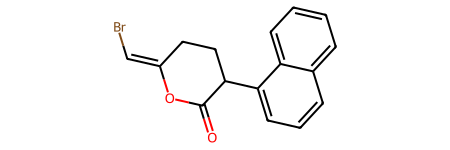

In [8]:
Chem.MolFromSmiles(df['canonical_smiles'].iloc[1])

In [9]:
(new_df['canonical_smiles'].iloc[0])

'O=C1O/C(=C/Br)CCC1c1cccc2ccccc12'

In [10]:
new_df.columns

Index(['molregno', 'canonical_smiles', 'activity_id', 'standard_type',
       'standard_value', 'standard_units', 'assay_id', 'tid',
       'target_chembl_id', 'organism', 'pref_name', 'mw_freebase', 'alogp',
       'hba', 'hbd', 'psa', 'rtb', 'ro3_pass', 'num_ro5_violations',
       'cx_most_apka', 'cx_most_bpka', 'cx_logp', 'cx_logd',
       'molecular_species', 'full_molformula', 'full_mwt', 'aromatic_rings',
       'heavy_atoms', 'qed_weighted', 'mw_monoisotopic', 'hba_lipinski',
       'hbd_lipinski', 'num_lipinski_ro5_violations', 'np_likeness_score',
       'bei', 'le', 'lle', 'sei'],
      dtype='object')

In [11]:
new_df['standard_type'].unique()

array(['Potency', 'IC50', 'Kd', 'Ki', 'Solubility', 'Km', 'MIC', 'XC50',
       'Selectivity', 'Cmax', 'MIC80', 'MIC50', 'Kp', 'LC50', 'Kinact',
       'GI50', 'MCC', 'CC50', 'Kb', 'pKi', 'TGI', 'pA2', 'IC95', 'TC50',
       'EC50', 'Inhibition', 'ID50', 'fCmax', 'Ratio', 'IC90', 'AC50',
       'ED50', 'Relative IC50', 'T50', 'Kieq', 'K bind', 'P-450 loss',
       'Kis', 'Activity', 'IC30', 'dP/dt', 'MIC90', 'fIC30', 'Protection',
       'Stability', 'Kd2', 'KiAH', 'C50', 'Ri', 'MEC', 'Rate',
       'Binding affinity', 'Plasma level', 'cKi', 'K0.5', 'fEC50',
       'Log Ki', 'Ke', 'CIC', 'Ka', 'IP', 'Ke naloxone', 'pKb', 'INH',
       'Plasma concentration', 'Residual activity', 'MI0.5', 'Ks',
       'K 0.5', 'Cytotoxicity', 'K app', 'KL', 'IC60', 'Log IC50', 'Kif',
       'SC200', 'EC20', 'KiH', 'Ca2+ elevation', 'Ratio Ki', 'K2',
       'alphaKi', 'MIC100', 'XI50', 'Inhibitory activity', 'Affinity',
       'Inflection point', 'Mortality', 'LD50', 'Fluorescence',
       'Ki app (inact

In [12]:
wanted_values = ['Potency', 'IC50', 'Kd', 'Ki', 'Solubility', 'Km', 'MIC', 'XC50',
       'Selectivity', 'Cmax', 'MIC80', 'MIC50', 'Kp', 'LC50', 'Kinact',
       'GI50', 'MCC', 'CC50', 'Kb', 'pKi', 'TGI', 'pA2', 'IC95', 'TC50',
       'EC50', 'Inhibition', 'ID50', 'fCmax', 'Ratio', 'IC90', 'AC50']

In [13]:
lip_df = new_df[(new_df['num_lipinski_ro5_violations'] == 0) & (new_df['hba_lipinski'] <= 10) & (new_df['mw_monoisotopic'] < 480) & (new_df['le']>0.3) & (new_df['lle']>3)]
print(lip_df.shape)
lip_df.head()

(118542, 38)


,molregno,canonical_smiles,activity_id,standard_type,standard_value,standard_units,assay_id,tid,target_chembl_id,organism,...,qed_weighted,mw_monoisotopic,hba_lipinski,hbd_lipinski,num_lipinski_ro5_violations,np_likeness_score,bei,le,lle,sei
3,25,C#C/C=C1\CCC(c2cccc3ccccc23)C(=O)O1,280316,IC50,95.0000,nM,156048,11934,CHEMBL3213,Homo sapiens,...,0.58,262.0994,2.0,0.0,0.0,0.52,26.77,0.48,3.24,26.70
5,31,COc1cc2nc(N3CCN(C(=O)C4CC4c4ccccc4)CC3)nc(N)c2...,325753,IC50,0.5129,nM,33572,104304,CHEMBL1907610,Rattus norvegicus,...,0.66,433.2114,8.0,2.0,0.0,-0.89,21.43,0.40,6.61,9.90
6,33,COc1cc2nc(N3CCN(S(=O)(=O)c4cccs4)CC3)nc(N)c2cc1OC,343861,IC50,33.8800,nM,33572,104304,CHEMBL1907610,Rattus norvegicus,...,0.65,435.1035,9.0,2.0,0.0,-1.78,17.15,0.35,5.67,6.74
20,59,COc1cc2nc(N3CCN(C(=O)CCc4ccccc4)CC3)nc(N)c2cc1OC,331005,IC50,3.3880,nM,33572,104304,CHEMBL1907610,Rattus norvegicus,...,0.65,421.2114,8.0,2.0,0.0,-0.91,20.10,0.37,5.96,9.03
21,60,COc1ccc(/C=C/C(=O)N2CCN(c3nc(N)c4cc(OC)c(OC)cc...,331003,IC50,3.3880,nM,33574,104304,CHEMBL1907610,Rattus norvegicus,...,0.57,449.2063,9.0,2.0,0.0,-0.67,18.84,0.35,5.87,8.22


Epoch 1/60
371/371 ━━━━━━━━━━━━━━━━━━━━ 489s 460ms/step - accuracy: 0.8051 - loss: 0.7212 - val_accuracy: 0.9000 - val_loss: 0.2994
Epoch 2/60
371/371 ━━━━━━━━━━━━━━━━━━━━ 27s 74ms/step - accuracy: 0.8985 - loss: 0.3026 - val_accuracy: 0.9139 - val_loss: 0.2525
Epoch 3/60
371/371 ━━━━━━━━━━━━━━━━━━━━ 27s 74ms/step - accuracy: 0.9107 - loss: 0.2617 - val_accuracy: 0.9196 - val_loss: 0.2326
Epoch 4/60
371/371 ━━━━━━━━━━━━━━━━━━━━ 27s 74ms/step - accuracy: 0.9165 - loss: 0.2421 - val_accuracy: 0.9240 - val_loss: 0.2193
Epoch 5/60
371/371 ━━━━━━━━━━━━━━━━━━━━ 27s 74ms/step - accuracy: 0.9204 - loss: 0.2296 - val_accuracy: 0.9261 - val_loss: 0.2121
Epoch 6/60
371/371 ━━━━━━━━━━━━━━━━━━━━ 27s 74ms/step - accuracy: 0.9232 - loss: 0.2211 - val_accuracy: 0.9285 - val_loss: 0.2048
Epoch 7/60
371/371 ━━━━━━━━━━━━━━━━━━━━ 27s 73ms/step - accuracy: 0.9254 - loss: 0.2140 - val_accuracy: 0.9301 - val_loss: 0.2002
Epoch 8/60
371/371 ━━━━━━━━━━━━━━━━━━━━ 27s 74ms/step - accuracy: 0.9272 - loss: 0.2085 

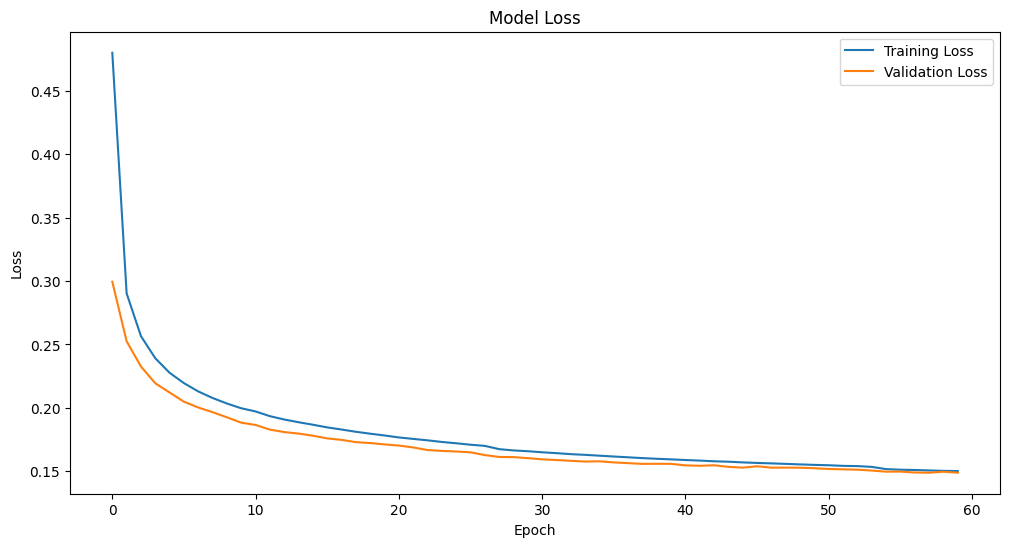

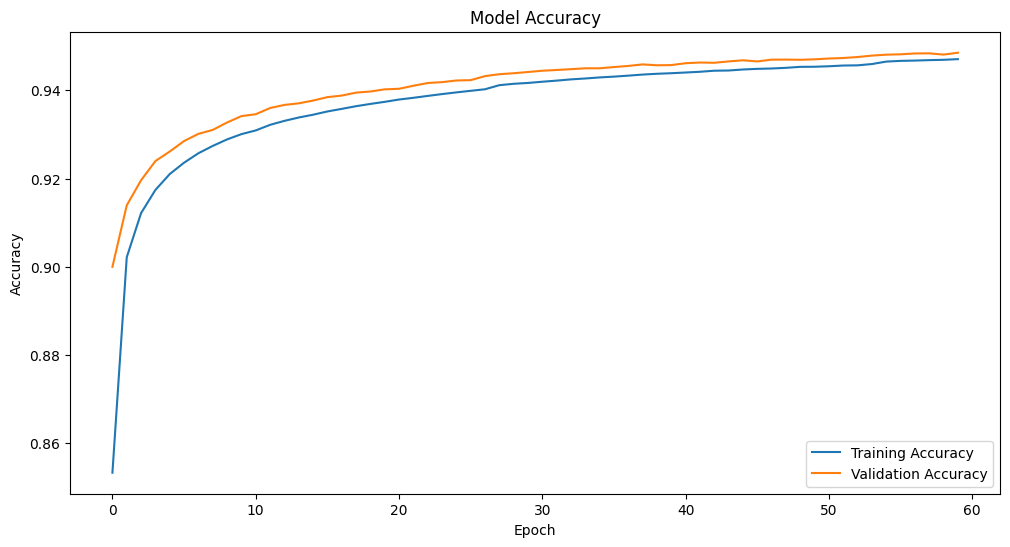

In [99]:
# Decoder only

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, MultiHeadAttention, LayerNormalization, Dense, Dropout, Add, TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Constants for the model
MODEL_DIM = 128
NUM_HEADS = 4
DROPOUT = 0.1
EPOCHS = 60
BATCH_SIZE = 256  # Adjust based on memory availability
LEARNING_RATE = 1e-3
NUM_LAYERS = 8
TEMPERATURE = 1.0  # Temperature for generation
CLIPVALUE = 1.0  # Gradient clipping value

# Prepare SMILES strings
smiles_list = lip_df['canonical_smiles'].tolist()

# Add special tokens with reserved indices
special_tokens = ['<PAD>', '<SOS>', '<EOS>']
vocab = special_tokens + list(set("".join(smiles_list)))  # Ensure special tokens are at the beginning

# Create character-to-index and index-to-character mappings
chars_to_index = {char: index for index, char in enumerate(vocab)}
index_to_chars = {index: char for index, char in enumerate(vocab)}

# Define the maximum length for padding (adding 2 for the <SOS> and <EOS> tokens)
max_length = max(len(smiles) for smiles in smiles_list) + 2

# Encode all SMILES strings
encoded_smiles_list = [
    [chars_to_index['<SOS>']] + [chars_to_index[char] for char in smiles] + [chars_to_index['<EOS>']]
    for smiles in smiles_list
]

# Pad sequences to the same length using <PAD> token
padded_smiles_list = pad_sequences(encoded_smiles_list, maxlen=max_length, padding='post', value=chars_to_index['<PAD>'])

# Convert to numpy array
X = np.array(padded_smiles_list)

# Create the target sequences (shifted by one time step)
y = np.zeros_like(X)
y[:, :-1] = X[:, 1:]
y[:, -1] = chars_to_index['<PAD>']

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Positional Encoding Function
def positional_encoding(position, d_model):
    angle_rads = np.arange(position)[:, np.newaxis] / np.power(10000, (2 * (np.arange(d_model)[np.newaxis, :] // 2)) / np.float32(d_model))
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

# Build the GPT-like decoder-only model
def build_decoder_only_model(input_shape, vocab_size, model_dim, num_heads, dropout_rate, num_layers):
    inputs = Input(shape=input_shape)
    x = Embedding(input_dim=vocab_size, output_dim=model_dim, mask_zero=True)(inputs)

    # Add positional encoding
    pos_encoding = positional_encoding(input_shape[0], model_dim)
    x = Add()([x, pos_encoding[:, :input_shape[0], :]])

    for _ in range(num_layers):
        # Decoder block
        attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=model_dim)(x, x, attention_mask=tf.linalg.band_part(tf.ones((input_shape[0], input_shape[0])), -1, 0))
        attn_output = Dropout(dropout_rate)(attn_output)
        out1 = LayerNormalization(epsilon=1e-6)(x + attn_output)

        ffn_output = Dense(model_dim, activation='relu')(out1)
        ffn_output = Dense(model_dim)(ffn_output)
        ffn_output = Dropout(dropout_rate)(ffn_output)
        x = LayerNormalization(epsilon=1e-6)(out1 + ffn_output)

    outputs = TimeDistributed(Dense(vocab_size, activation='softmax'))(x)
    model = Model(inputs, outputs)
    return model

# Instantiate the model
decoder_only_model = build_decoder_only_model(
    input_shape=(max_length,),
    vocab_size=len(vocab),
    model_dim=MODEL_DIM,
    num_heads=NUM_HEADS,
    dropout_rate=DROPOUT,
    num_layers=NUM_LAYERS
)

# Compile the model with gradient clipping
optimizer = Adam(learning_rate=ExponentialDecay(
    initial_learning_rate=LEARNING_RATE,
    decay_steps=10000,
    decay_rate=0.9,
    staircase=True
), clipvalue=CLIPVALUE)

decoder_only_model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Configure early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with early stopping
history = decoder_only_model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()


In [100]:
# Function to generate SMILES strings with temperature scaling
def generate_smiles(model, start_token, max_length, chars_to_index, index_to_chars, temperature=1.0):
    # Initialize the input sequence with the start token
    input_seq = [chars_to_index[start_token]]
    for _ in range(max_length - 1):
        # Pad the sequence
        padded_seq = pad_sequences([input_seq], maxlen=max_length, padding='post', value=chars_to_index['<PAD>'])
        # Predict the next character
        pred = model.predict(padded_seq, verbose=0)
        pred = pred[0][len(input_seq) - 1]

        # Apply temperature scaling
        pred = np.log(pred + 1e-9) / temperature
        exp_pred = np.exp(pred)
        pred = exp_pred / np.sum(exp_pred)
        next_char = np.random.choice(len(pred), p=pred)

        # Append the next character to the sequence
        input_seq.append(next_char)

        # If EOS token is generated, stop the generation
        if next_char == chars_to_index['<EOS>']:
            break

    # Convert the sequence of indices to characters
    smiles = ''.join([index_to_chars[i] for i in input_seq if i != chars_to_index['<PAD>'] and i != chars_to_index['<EOS>']])
    print(smiles.split("<SOS>")[-1])
    return smiles.split("<SOS>")[-1]

def evaluate_generated_smiles(generated_smiles_list, training_smiles_list):
    from rdkit import Chem
    from rdkit import RDLogger

    # Function to check the validity of generated SMILES strings using RDKit
    def is_valid_smiles(smiles):
        mol = Chem.MolFromSmiles(smiles)
        return mol is not None

    # Suppress RDKit warnings
    RDLogger.DisableLog('rdApp.*')

    valid_smiles = []

    for smiles in generated_smiles_list:
        if is_valid_smiles(smiles) and len(smiles) > 0:
            valid_smiles.append(smiles)

    validity = len(valid_smiles) / len(generated_smiles_list) * 100
    unique_smiles = list(set(valid_smiles))
    not_unique = 0
    for smiles in training_smiles_list:
      if smiles in unique_smiles:
        not_unique += 1

    # percent unique = number found in training set - unique smiles / total valid smiles
    unique = (len(unique_smiles)-not_unique)/len(valid_smiles) * 100

    # Re-enable RDKit warnings if needed
    RDLogger.EnableLog('rdApp.*')

    return validity, unique, list(set(valid_smiles))

# Generate a new SMILES string
new_smiles = generate_smiles(decoder_only_model, start_token='<SOS>', max_length=max_length, chars_to_index=chars_to_index, index_to_chars=index_to_chars, temperature=TEMPERATURE)
print(f"Generated SMILES: {new_smiles}")
generated_smiles_list = []
for i in tqdm(range(100)):
    generated_smiles = generate_smiles(decoder_only_model, start_token='<SOS>', max_length=max_length, chars_to_index=chars_to_index, index_to_chars=index_to_chars, temperature=TEMPERATURE)
    generated_smiles_list.append(generated_smiles)

validity, uniqueness, unique_valid_smiles = evaluate_generated_smiles(generated_smiles_list, smiles_list)
print(f"\nPercent valid: {validity:.3f}%")
print(f"Percent unique: {uniqueness:.3f}%")
print(unique_valid_smiles)

N=C(N)OP(=O)(O)O
Generated SMILES: N=C(N)OP(=O)(O)O


  1%|          | 1/100 [00:03<05:34,  3.38s/it]

O=C1O/C(=C\C(=O)Nc2ccc(Cl)c(F)c2)S(=O)(=O)c2cc(F)cc(F)c21


  2%|▏         | 2/100 [00:05<04:10,  2.55s/it]

O=C(CC#Cc1ccc(O)c(O)c1)Nc1ccccc1O


  3%|▎         | 3/100 [00:07<03:36,  2.23s/it]

Cc1ncn2c1Cn1ncnc1-c1sc(Cl)cc1-2


  4%|▍         | 4/100 [00:10<04:16,  2.67s/it]

CC1(C)n2c(S(=O)(=O)c3ccc(S(N)(=O)=O)cc3)cc3cccnc32)C1(C)C


  5%|▌         | 5/100 [00:13<04:11,  2.65s/it]

O=C1NCC2c3c(sc31)CCCN2C(=O)Nc1ccc2[nH]ccc2c1


  6%|▌         | 6/100 [00:15<03:56,  2.52s/it]

N#Cc1ccc2[nH]c(CC3(CO)CCCC3)c(CCN)c2c1


  7%|▋         | 7/100 [00:17<03:36,  2.33s/it]

O=C1NC(=S)S/C1=C\c1ccc2c(c1)CCN2


  8%|▊         | 8/100 [00:20<03:49,  2.49s/it]

COC(=O)c1cc(Nc2nc(N3CCOCC3)nc(N3CCCC3)n2)ccc1OC


  9%|▉         | 9/100 [00:25<05:19,  3.51s/it]

Cc1ncc(CC2C3CCC(O3)C2C(=O)N[C@H]2CCCCN3C(=O)[C@@H](CC(C)C)C[C@@H](N)C(=O)N3CCCc4cccc412)c1.O.O=C(O


 10%|█         | 10/100 [00:28<04:40,  3.12s/it]

Br.Br.N=C(Nc1ccc(O)c(O)c1)SCCCc1ccccc1


 11%|█         | 11/100 [00:30<04:28,  3.02s/it]

CC(=O)OCC1CC=C2C(=O)C=CC2C1=O.O=C(O)/C=C/C(=O)O


 12%|█▏        | 12/100 [00:35<05:19,  3.63s/it]

CN1Cc2c(S(=O)(=O)c3ccc(OC(F)F)cc3)ccc(F)c2CC1C(=O)O


 13%|█▎        | 13/100 [00:37<04:32,  3.13s/it]

COc1cc2c(cc1OC)-c1n[nH]nc1C2


 14%|█▍        | 14/100 [00:42<04:52,  3.40s/it]

COC(=O)c1cc(C)c(C)c(N(Cc2ccc(C#N)cc2)S(=O)(=O)c2ccccc2C)c1


 15%|█▌        | 15/100 [00:43<04:05,  2.89s/it]

CNCCC(c1ccccc1)P(=O)(O)O


 16%|█▌        | 16/100 [00:46<04:03,  2.90s/it]

Cl.Nc1ccc(S(=O)(=O)N2CCC(C(=O)NO)CC2)cc1


 17%|█▋        | 17/100 [00:49<03:52,  2.80s/it]

CCN(CC)C(=O)c1ccc2c(c1)C(=O)C(=O)N2


 18%|█▊        | 18/100 [00:52<04:01,  2.94s/it]

CC(=O)N1CCC(c2ccc(C(=O)NC(=O)NCC3CCCCC3)cc2)CC1


 19%|█▉        | 19/100 [00:56<04:35,  3.40s/it]

N#C[C@@H]1CCCN1C(=O)[C@@H](N)CCC(=O)N1CCc2ccccc2C1.O=C(O)C(F)(F)F


 20%|██        | 20/100 [00:58<03:52,  2.91s/it]

NS(=O)(=O)c1cc2c(s1)OCCO2


 21%|██        | 21/100 [01:01<03:39,  2.78s/it]

CC(C)(C)NCC(O)COC(=O)c1ccc(F)c(F)c1


 22%|██▏       | 22/100 [01:05<04:01,  3.10s/it]

COc1cccc2c1nc(C(=O)N3CCN(C4CC4)CC3)n2-c1ccc(C(F)(F)F)cc1


 23%|██▎       | 23/100 [01:06<03:27,  2.69s/it]

CCc1ccccc1OCCN1CCC[C@H]1C


 24%|██▍       | 24/100 [01:08<03:13,  2.55s/it]

C=C/C=C/c1nc(C)nc(NCc2ccccc2)c1N


 25%|██▌       | 25/100 [01:10<02:46,  2.22s/it]

Cn1cnc(S(=O)(=O)NN)c1


 26%|██▌       | 26/100 [01:12<02:45,  2.24s/it]

Nc1nc(C2CC2)nc2c1nnn2CC1CCCC(F)O1


 27%|██▋       | 27/100 [01:15<02:45,  2.27s/it]

CCCS(=O)(=O)Cc1cccc(CC)c1OCC(=O)O


 28%|██▊       | 28/100 [01:18<03:01,  2.52s/it]

Cc1cccnc1Cc1nc2cc(Br)cc(C(=O)N(C)CC=O)c2[nH]1


 29%|██▉       | 29/100 [01:20<03:04,  2.59s/it]

O=C(N[C@H]1CN2CCC1CC2)c1cnnc(-c2ccccc2)c1


 30%|███       | 30/100 [01:23<03:04,  2.64s/it]

CN1C(=O)C2C(N=C(Nc3cccc(I)c3)N2C)N(C)C1=O


 31%|███       | 31/100 [01:24<02:31,  2.20s/it]

Cn1nnnn1-c1ccccc1


 32%|███▏      | 32/100 [01:28<02:59,  2.64s/it]

CN(C)C(=O)COc1ccc(Nc2nc(-c3ccccc3)nc3cnn(C(C)C)c23)cc1


 33%|███▎      | 33/100 [01:30<02:50,  2.54s/it]

C#Cc1cccc(Cn2c(=O)oc3c(C)cccc32)c1


 34%|███▍      | 34/100 [01:33<02:49,  2.58s/it]

COc1ccc(-c2nnc(N3CCC(N4CCCCC4)CC3)s2)cc1


 35%|███▌      | 35/100 [01:36<02:47,  2.57s/it]

CCn1c(=O)c2nc(-c3ccncc3)[nH]c2n(CC)c1=O


 36%|███▌      | 36/100 [01:39<02:54,  2.72s/it]

O=C(Oc1cncc(-c2ccc(F)c(C(F)(F)F)c2)c1)OC1CCCCC1


 37%|███▋      | 37/100 [01:41<02:49,  2.69s/it]

COc1ccccc1N1CCN(CN2C(=O)c3ccccc3C2=O)CC1


 38%|███▊      | 38/100 [01:44<02:43,  2.64s/it]

COc1cc(NCc2ccc(F)cc2)c2c(C)cc(C)cc2c1


 39%|███▉      | 39/100 [01:47<02:49,  2.78s/it]

Cc1cccc(COc2nn3c(-c4ccccc4)nnc3c3c2C2CCC3CC2)n1


 40%|████      | 40/100 [01:52<03:30,  3.51s/it]

CN[C@@H]1C[C@@H]2CCC[C@@]3(C)[C@H]4Cc5scc6c5c5c5c(C3)[C@H]2CC[C@@]2(CCNC1)C(=O)O5


 41%|████      | 41/100 [01:54<02:59,  3.04s/it]

CCOC(=O)c1c(C)nc2c(ccn2CCO)c1N


 42%|████▏     | 42/100 [01:58<03:10,  3.28s/it]

COc1cc(OC)c2oc(-c3nc(OC)n4nc(-c5ccco5)nc4n3)c(C)c(=O)c2c1


 43%|████▎     | 43/100 [01:59<02:35,  2.72s/it]

COc1cc(O)cc(C(=O)O)c1


 44%|████▍     | 44/100 [02:02<02:31,  2.71s/it]

CC(=O)N1CCN(C(=O)CCCOc2ccc3c(c2)CCCC3)CC1


 45%|████▌     | 45/100 [02:05<02:28,  2.70s/it]

Cn1cc(-c2ccc3c(c2)CC/C3=N\O)c(-c2ccncn2)n1


 46%|████▌     | 46/100 [02:07<02:26,  2.70s/it]

O=C1c2ccc(O)c(O)c2C(=O)N1Cc1cc(Cl)cc(Cl)c1


 47%|████▋     | 47/100 [02:10<02:19,  2.63s/it]

COc1cc(-n2cc3c(c2)CC(C)C3)cc(C(C)C)c1N


 48%|████▊     | 48/100 [02:14<02:34,  2.97s/it]

N#Cc1ccc(Cn2nncc2O)cc1OCc1cc(Cc2cccc(C#N)c2nn[nH]n2)ccc1


 49%|████▉     | 49/100 [02:17<02:41,  3.16s/it]

O=C(O)C[C@@H](c1ccc(Cc2ccc(=O)n(-c3ccccc3)n2)cc1)N1CCCC1


 50%|█████     | 50/100 [02:19<02:23,  2.87s/it]

CCOC(=O)C1C(c2ccc(C)cc2)CC2CCC1N2C


 51%|█████     | 51/100 [02:22<02:19,  2.84s/it]

COc1ccc(S(=O)(=O)n2ccc3ccc(CCN(C)C)cc32)cc1


 52%|█████▏    | 52/100 [02:25<02:15,  2.82s/it]

O=Cc1nn(-c2ccccc2)cc1-c1cc2c([nH]1)CCNC2=O


 53%|█████▎    | 53/100 [02:28<02:19,  2.96s/it]

CCOC(=O)[C@H](CCN(O)C=O)c1cc(C)cc(OCCCc2ccccc2)c1


 54%|█████▍    | 54/100 [02:30<01:58,  2.58s/it]

Cn1cnc2cccc(OCc3ccccc3)c21


 55%|█████▌    | 55/100 [02:33<02:03,  2.75s/it]

COc1cccc(CNc2nc(NCCCO)c3ncn(C(C)C)c3n2)c1C(F)(F)F


 56%|█████▌    | 56/100 [02:37<02:11,  3.00s/it]

CCCCN(CCCCN1C(=O)CC2(CCCC2)CC1=O)C1CSC1.O=C(O)C(O)C(O)=O


 57%|█████▋    | 57/100 [02:39<01:57,  2.72s/it]

CC(C)n1nc(-c2ccncn2)c2c(N)ncnc21


 58%|█████▊    | 58/100 [02:42<01:55,  2.76s/it]

O=C(CCCCN1CCN(c2nsc3ccccc23)CC1)c1ccc(F)cc1


 59%|█████▉    | 59/100 [02:45<01:56,  2.85s/it]

CN(C)C(=O)C(Cc1ccccc1Cl)NC(=O)c1ccc(C(C)(C)C)cc1


 60%|██████    | 60/100 [02:48<02:05,  3.13s/it]

Cc1cc(C)cc(Nc2nc(C34CC4CC3C4)nn3cc(C(=O)c4c(C)noc4C)ccc23)c1


 61%|██████    | 61/100 [02:50<01:47,  2.75s/it]

OC1(c2cnc3ccccc3c2)CN2CCC1CC2


 62%|██████▏   | 62/100 [02:52<01:37,  2.58s/it]

O=C(O)CNC(=O)C1C(c2ccc(F)cc2)CCCC1


 63%|██████▎   | 63/100 [02:57<01:54,  3.10s/it]

CCOc1ccc2c(c1)CCN1C[C@H]3CCCN(S(=O)(=O)Cc4cccc(F)c4)[C@@H]3C[C@@H]21


 64%|██████▍   | 64/100 [03:01<02:02,  3.40s/it]

COC(=O)[C@H]1CC(O)[C@@H]2[C@@H](C1)N(C(=O)[C@@H](C)O)[C@H]2C(=O)OC


 65%|██████▌   | 65/100 [03:04<01:54,  3.28s/it]

Cc1ccc(-c2ccc(=O)oc2)c(C(=O)Nc2ccc(Cl)c(Cl)c2)n1


 66%|██████▌   | 66/100 [03:06<01:38,  2.89s/it]

C/C(C#Cc1ccc(C#N)cc1)=C/CC(=O)O


 67%|██████▋   | 67/100 [03:07<01:22,  2.49s/it]

c1ccc(Cc2nnc3nccn3n2)cc1


 68%|██████▊   | 68/100 [03:10<01:18,  2.47s/it]

Nc1ncnc2c1ncn2C1SC(=O)N(CCC(=O)O)C1=O


 69%|██████▉   | 69/100 [03:13<01:21,  2.63s/it]

CN1C(=O)C=C(C(=O)OCc2ccccc2)CC(c2ccccc2)N(C)C1=O


 70%|███████   | 70/100 [03:17<01:29,  2.98s/it]

CS(=O)(=O)c1ccc(C(=O)N[C@@H](C(=O)NCc2ccc(Cl)cc2)C(C)(C)C)cc1


 71%|███████   | 71/100 [03:19<01:20,  2.77s/it]

N#Cc1ccc(-c2cc(Br)cc(C(F)(F)F)c2)cc1


 72%|███████▏  | 72/100 [03:22<01:19,  2.85s/it]

CCCCn1c(=O)c2[nH]c(-c3csc(CCC#N)n3)nc2n(CCC)c1=O


 73%|███████▎  | 73/100 [03:25<01:19,  2.94s/it]

Cc1nc2c(N)cccc2n1-c1ccc(C(=O)NC[C@@H]2CCCN2CCO)s1


 74%|███████▍  | 74/100 [03:29<01:20,  3.09s/it]

C=CCN1CC(=O)N2C[C@@H](C)N(c3nc4ccccc4c(C)n3)C[C@H]2C1=O


 75%|███████▌  | 75/100 [03:32<01:17,  3.11s/it]

O=c1cc(C(F)(F)F)c2cc3c(cc2o1)NCC(CCCCc1nn[nH]n1)C3


 76%|███████▌  | 76/100 [03:34<01:08,  2.85s/it]

O=C(O)[C@@H]1NCC[C@H]1c1ccc2ccccc2n1


 77%|███████▋  | 77/100 [03:35<00:56,  2.44s/it]

CN1CCC[C@H](c2ccccc2)C1


 78%|███████▊  | 78/100 [03:36<00:42,  1.92s/it]

CCCn1ccnc1


 79%|███████▉  | 79/100 [03:40<00:54,  2.61s/it]

CC(C)[C@H](NS(=O)(=O)c1ccc(Cl)cc1)C(=O)N[C@H](C=O)Cc1c[nH]c2ccccc12


 80%|████████  | 80/100 [03:44<00:58,  2.93s/it]

Cn1nc(-c2ccc(N3C[C@H]4C(CN5CCC4CC5=O)[C@H](C4)C3)cc2)ccc1=O


 81%|████████  | 81/100 [03:47<00:56,  3.00s/it]

CCCN(CCCCN1C(=O)C(C)C1=O)[C@@H]1Oc2c(O)ccc(C)c2C1=O


 82%|████████▏ | 82/100 [03:51<01:00,  3.34s/it]

Cc1cc(C)c2cc([C@H](C)[C@](C)(C(F)(F)F)[C@@H]3CCCNC3)c(C)c(=O)n2c1


 83%|████████▎ | 83/100 [03:53<00:49,  2.92s/it]

CC(Oc1ccccc1CN1CCOCC1)C1=NCCN1


 84%|████████▍ | 84/100 [03:57<00:48,  3.05s/it]

COc1cccc2c1CCC(N(C)CCCN1C(=O)c3c(c4ccccc4n3C)CC1=O)C2


 85%|████████▌ | 85/100 [03:58<00:40,  2.71s/it]

c1cc(C2=NNCCO2)cc(C(F)(F)F)c1


 86%|████████▌ | 86/100 [04:00<00:33,  2.41s/it]

CNc1cc(Cl)nc(NCc2ccccc2)n1


 87%|████████▋ | 87/100 [04:04<00:36,  2.81s/it]

N#Cc1cccnc1N1CCc2ccc3cc(-c4ccnc(NS(=O)(=O)c5ccccc5)n4)sc3c21


 88%|████████▊ | 88/100 [04:07<00:33,  2.76s/it]

COc1ccc(S(=O)(=O)N(Cc2ccccc2)N2CCNCC2)cc1


 89%|████████▉ | 89/100 [04:09<00:28,  2.58s/it]

NC(=O)c1ccc2[nH]c(-c3ccccc3O)nc2c1


 90%|█████████ | 90/100 [04:11<00:25,  2.54s/it]

COC(=O)C1=C(c2cc(Cl)c(Cl)cc2)CC2CCC1N2C


 91%|█████████ | 91/100 [04:15<00:25,  2.89s/it]

[3H]c1ccc([C@@H]2C[C@H]3CC[C@H](C2C(=O)OC2(CO)CC3)N3C)c(F)c1


 92%|█████████▏| 92/100 [04:18<00:23,  2.92s/it]

O=C1/C(=C/c2cn(Cc3ccc(F)cc3)c3ccccc23)Oc2ccncc21


 93%|█████████▎| 93/100 [04:21<00:21,  3.03s/it]

N#Cc1ccccc1CSc1nc2cc(C(F)(F)F)c(=O)n(CC(F)(F)F)c2n1


 94%|█████████▍| 94/100 [04:25<00:19,  3.22s/it]

Cc1cccc(NC(=O)N[C@H]2N=C(c3ccc(F)c(F)c3)c3ccccc3N(C)C2=O)n1


 95%|█████████▌| 95/100 [04:27<00:15,  3.04s/it]

Cc1ccc2[nH]c(C(=O)OCCCCCc3ccc(Br)cc3)nc2c1


 96%|█████████▌| 96/100 [04:31<00:12,  3.18s/it]

COc1ccc([C@H]2c3[nH]c4ccccc4c3C[C@H]3C(=O)NC(=O)N23)cc1


 97%|█████████▋| 97/100 [04:33<00:08,  2.80s/it]

Oc1nc2ccccc2n2nc(-c3ccco3)nc12


 98%|█████████▊| 98/100 [04:35<00:05,  2.64s/it]

CN(C)c1ccc(-c2nn(C)cc2-c2ccccc2)cc1


 99%|█████████▉| 99/100 [04:38<00:02,  2.61s/it]

O=C(Nc1ccc2[nH]nc(NC3CCNCC3)c2c1)c1cccs1


100%|██████████| 100/100 [04:42<00:00,  2.82s/it]

Cc1cc(C(F)(F)F)nn1-c1ccnc(N[C@H](C(=O)N3CCC[C@H]3C#N)C3(C)C)n1

Percent valid: 89.000%
Percent unique: 93.258%
['C=C/C=C/c1nc(C)nc(NCc2ccccc2)c1N', 'CCCCn1c(=O)c2[nH]c(-c3csc(CCC#N)n3)nc2n(CCC)c1=O', 'CN1CCC[C@H](c2ccccc2)C1', 'CNc1cc(Cl)nc(NCc2ccccc2)n1', 'O=C(Nc1ccc2[nH]nc(NC3CCNCC3)c2c1)c1cccs1', 'CC(=O)N1CCC(c2ccc(C(=O)NC(=O)NCC3CCCCC3)cc2)CC1', 'N#C[C@@H]1CCCN1C(=O)[C@@H](N)CCC(=O)N1CCc2ccccc2C1.O=C(O)C(F)(F)F', 'COc1cc(-n2cc3c(c2)CC(C)C3)cc(C(C)C)c1N', 'Cc1cccc(COc2nn3c(-c4ccccc4)nnc3c3c2C2CCC3CC2)n1', 'Cc1cccc(NC(=O)N[C@H]2N=C(c3ccc(F)c(F)c3)c3ccccc3N(C)C2=O)n1', 'O=C1/C(=C/c2cn(Cc3ccc(F)cc3)c3ccccc23)Oc2ccncc21', 'COc1ccc(-c2nnc(N3CCC(N4CCCCC4)CC3)s2)cc1', 'c1cc(C2=NNCCO2)cc(C(F)(F)F)c1', 'O=C(CC#Cc1ccc(O)c(O)c1)Nc1ccccc1O', 'COc1ccc(S(=O)(=O)n2ccc3ccc(CCN(C)C)cc32)cc1', 'OC1(c2cnc3ccccc3c2)CN2CCC1CC2', 'CCc1ccccc1OCCN1CCC[C@H]1C', 'CCOc1ccc2c(c1)CCN1C[C@H]3CCCN(S(=O)(=O)Cc4cccc(F)c4)[C@@H]3C[C@@H]21', 'CN1C(=O)C=C(C(=O)OCc2ccccc2)CC(c2ccccc2)N(C)C1=O', 'COC(=O)c1cc(C)c(C)c(N(C

In [101]:
decoder_only_model.save("/content/drive/MyDrive/InspiritAI/1:1Mentorship/sanjay_oruganti/TD_128_L8_H4.keras")

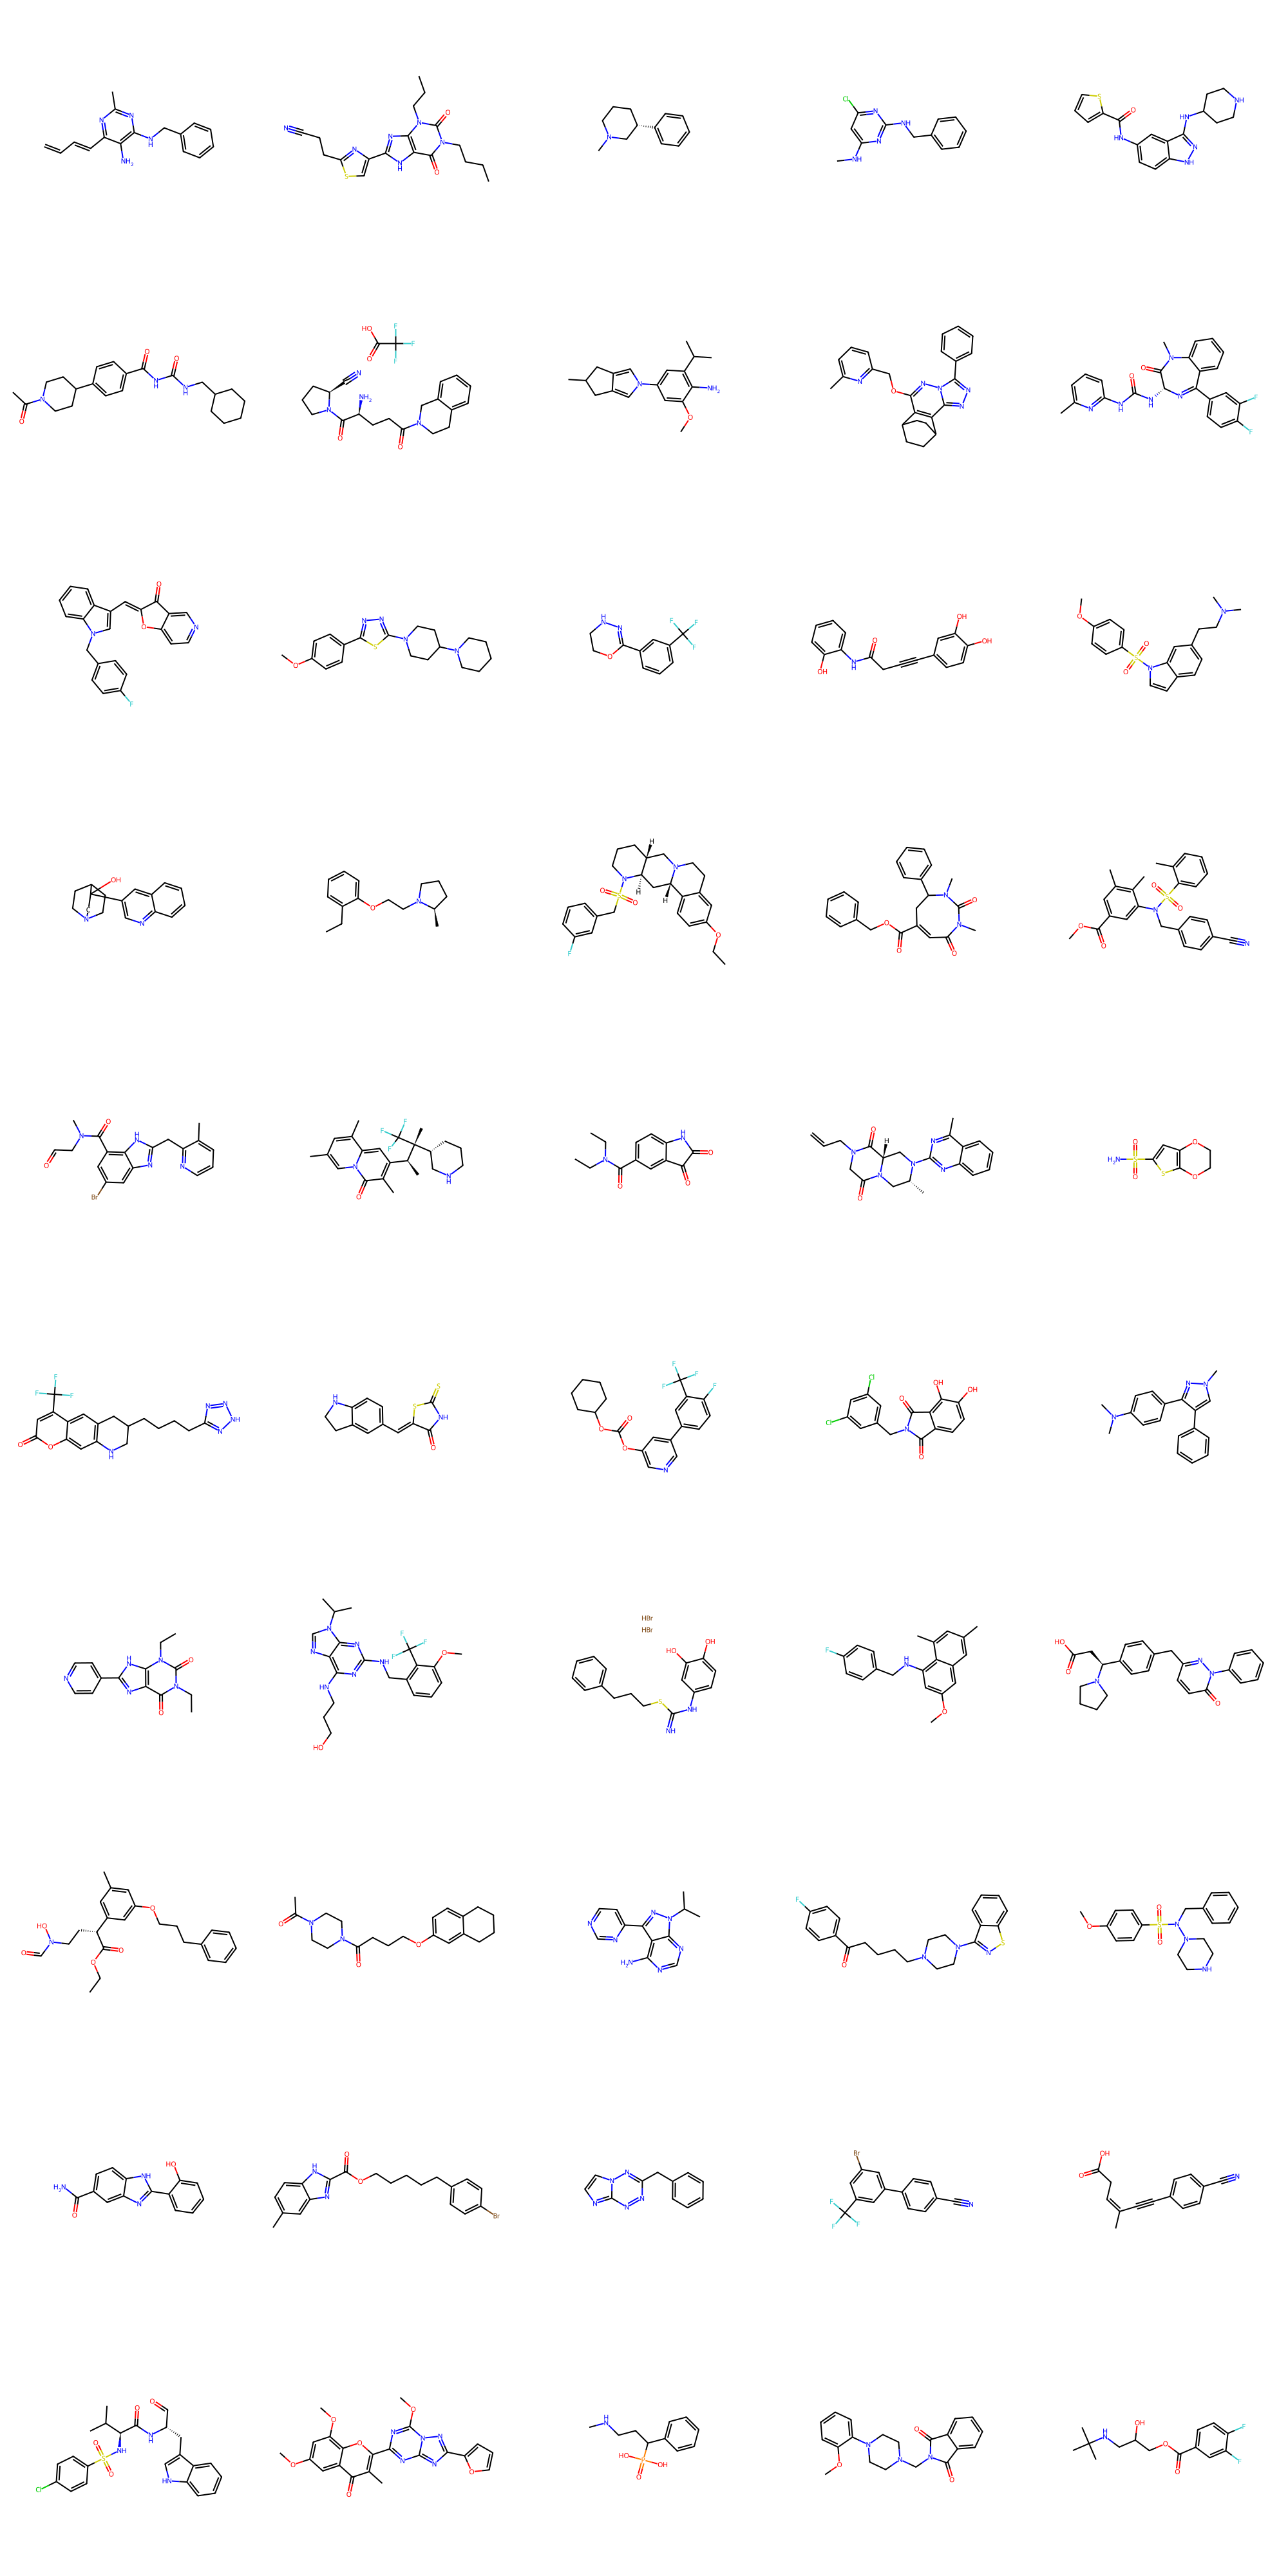

In [102]:
# Example: Display the first 10 unique valid SMILES strings as a grid image
molecule_list = [Chem.MolFromSmiles(smiles) for smiles in unique_valid_smiles[:50]]

# Generate a grid image of the molecules
# Adjust 'subImgSize' for the size of each molecule image, and 'molsPerRow' for the layout
grid_image = Draw.MolsToGridImage(molecule_list, molsPerRow=5, subImgSize=(400, 400))

# Display the grid image
display(grid_image)

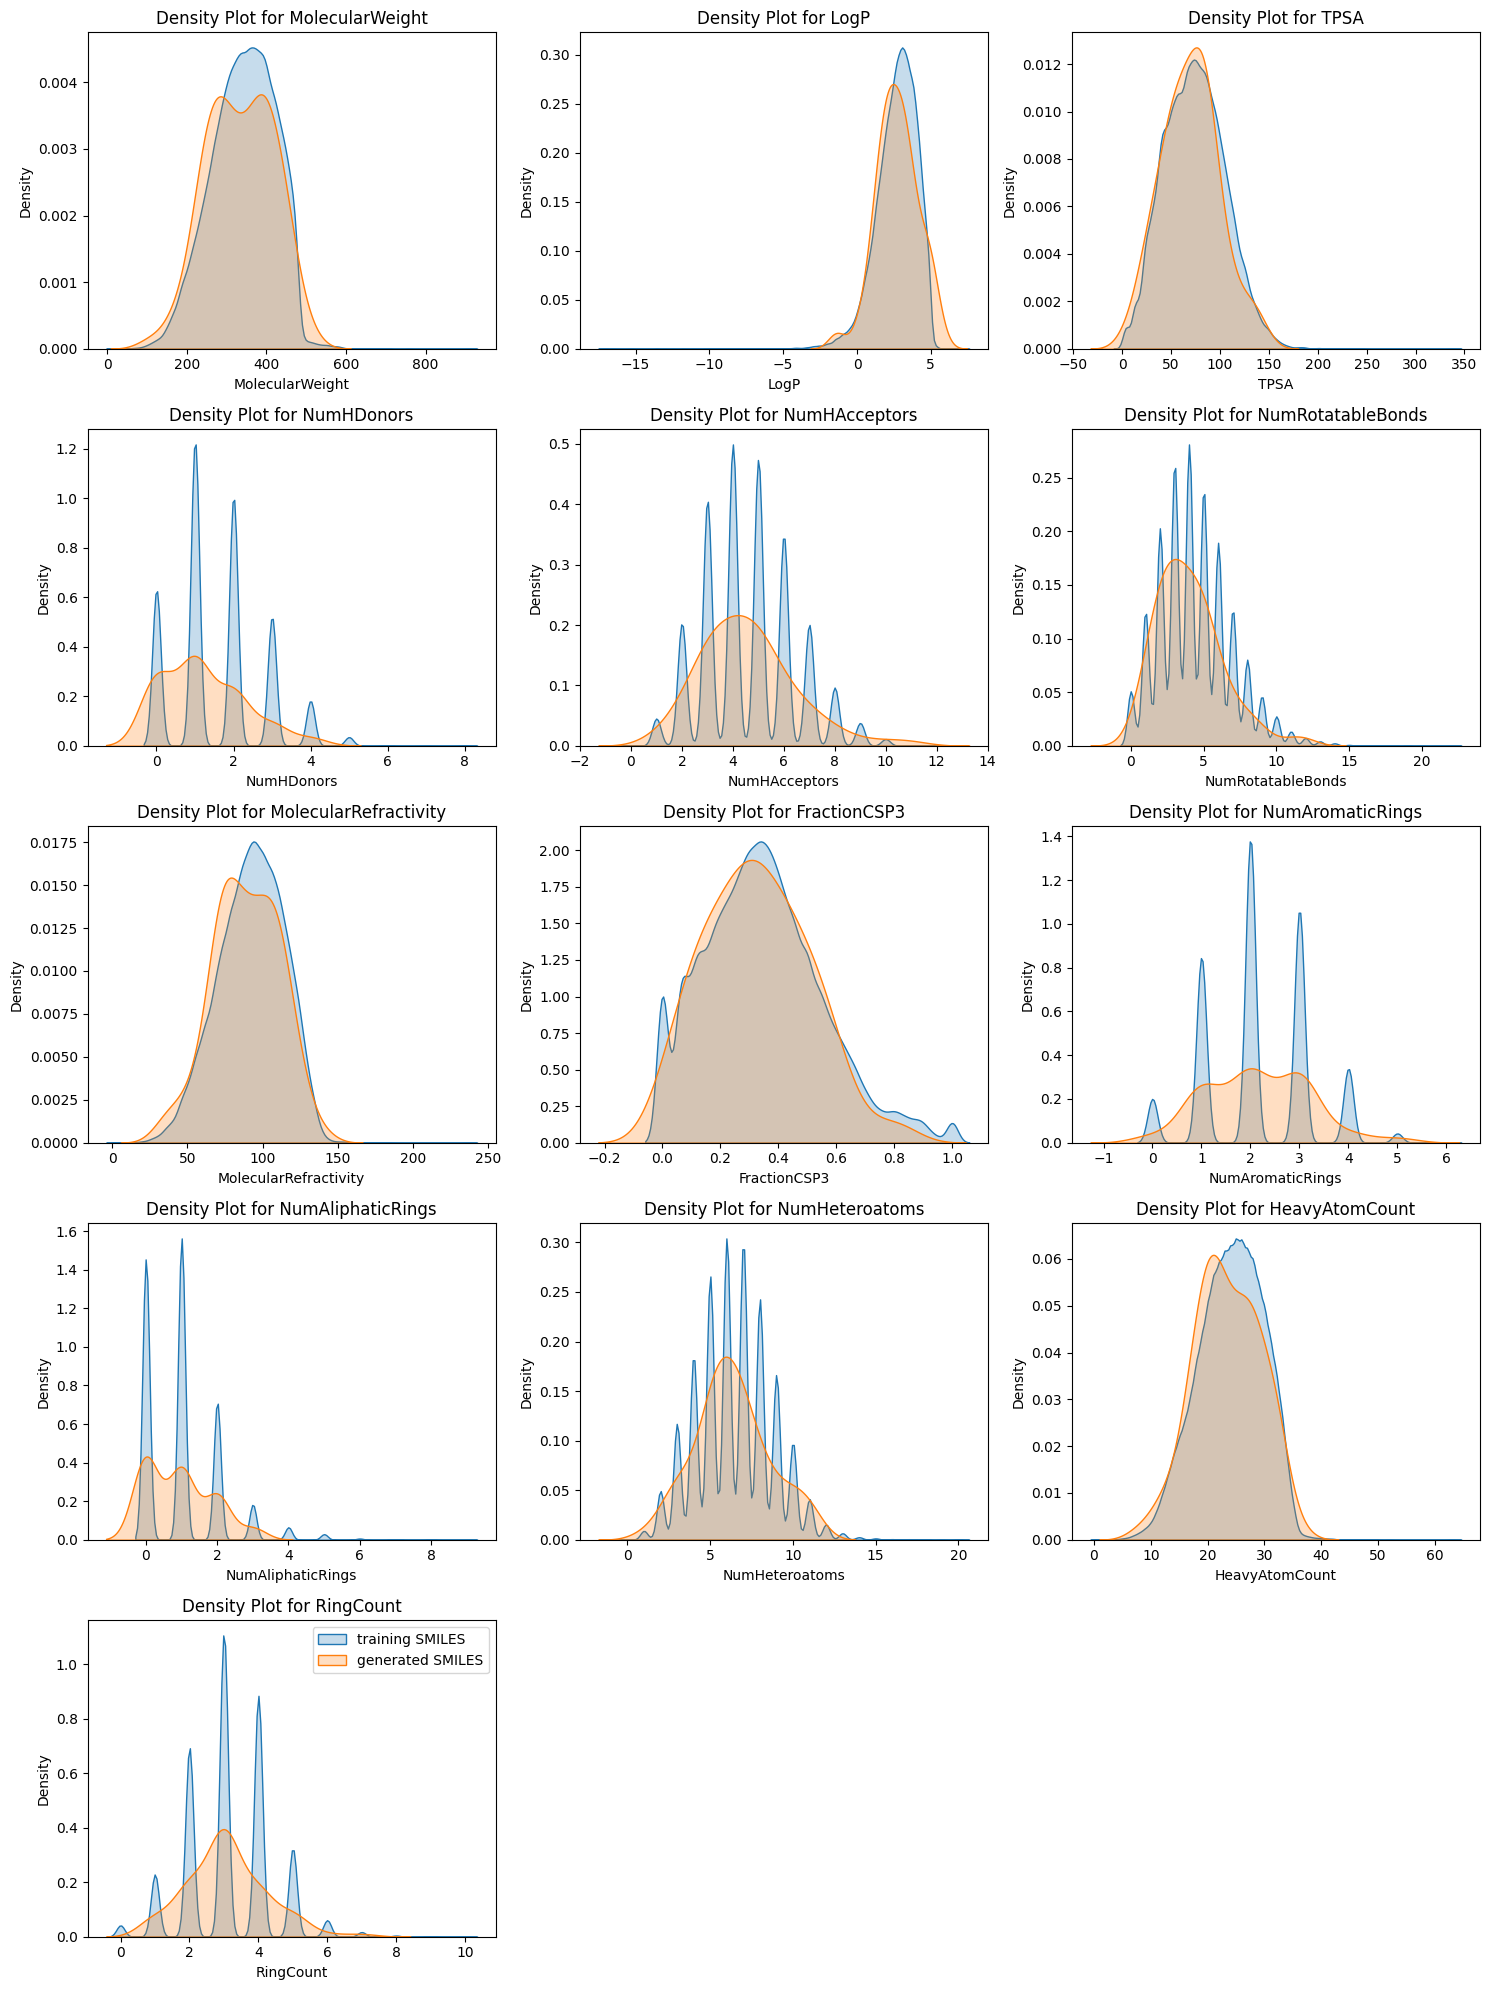

In [103]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors


# Define a function to compute descriptors for a given SMILES string
def compute_descriptors(smiles):
    molecule = Chem.MolFromSmiles(smiles)
    if molecule is not None:
        return {
            # Molecular Weight: The sum of atomic weights in the molecule.
            'MolecularWeight': Descriptors.MolWt(molecule),

            # LogP: The logarithm of the octanol-water partition coefficient, indicating hydrophobicity.
            'LogP': Descriptors.MolLogP(molecule),

            # Topological Polar Surface Area (TPSA): The surface area of polar atoms, associated with drug absorption.
            'TPSA': Descriptors.TPSA(molecule),

            # Number of Hydrogen Bond Donors: Atoms in the molecule that can donate hydrogen bonds (e.g., -OH, -NH).
            'NumHDonors': Descriptors.NumHDonors(molecule),

            # Number of Hydrogen Bond Acceptors: Atoms in the molecule that can accept hydrogen bonds (e.g., O, N).
            'NumHAcceptors': Descriptors.NumHAcceptors(molecule),

            # Number of Rotatable Bonds: Single bonds that allow free rotation, contributing to molecular flexibility.
            'NumRotatableBonds': Descriptors.NumRotatableBonds(molecule),

            # Molecular Refractivity: Related to the molecule's polarizability and volume.
            'MolecularRefractivity': Descriptors.MolMR(molecule),

            # Fraction of sp3 Carbons (Csp3): The ratio of sp3-hybridized carbons to the total number of carbons.
            'FractionCSP3': Descriptors.FractionCSP3(molecule),

            # Number of Aromatic Rings: Counts the number of rings with delocalized pi-electron systems.
            'NumAromaticRings': Descriptors.NumAromaticRings(molecule),

            # Number of Aliphatic Rings: Counts the number of non-aromatic cyclic structures.
            'NumAliphaticRings': Descriptors.NumAliphaticRings(molecule),

            # Number of Heteroatoms: Atoms other than carbon and hydrogen (e.g., N, O, S).
            'NumHeteroatoms': Descriptors.NumHeteroatoms(molecule),

            # Number of Heavy Atoms: Atoms in the molecule that are not hydrogen.
            'HeavyAtomCount': Descriptors.HeavyAtomCount(molecule),

            # Total Number of Rings: Counts all rings in the molecule, both aromatic and aliphatic.
            'RingCount': Descriptors.RingCount(molecule),
        }
    else:
        # Return NaNs or a default value for invalid SMILES strings
        return {
            'MolecularWeight': float('nan'),
            'LogP': float('nan'),
            'TPSA': float('nan'),
            'NumHDonors': float('nan'),
            'NumHAcceptors': float('nan'),
            'NumRotatableBonds': float('nan'),
            'MolecularRefractivity': float('nan'),
            'FractionCSP3': float('nan'),
            'NumAromaticRings': float('nan'),
            'NumAliphaticRings': float('nan'),
            'NumHeteroatoms': float('nan'),
            'HeavyAtomCount': float('nan'),
            'RingCount': float('nan'),
        }

# Create dataframes from generated SMILES data to store molecular descriptors
training_df = pd.DataFrame(smiles_list, columns=['SMILES'])
generated_df = pd.DataFrame(unique_valid_smiles, columns=['SMILES'])

# Apply the descriptor function to each row in the dataframe
descriptor_columns = training_df['SMILES'].apply(compute_descriptors)
descriptor_columns_gen = generated_df['SMILES'].apply(compute_descriptors)

# Convert the series of dictionaries into a DataFrame
descriptors_df = pd.DataFrame(descriptor_columns.tolist())
descriptors_gen_df = pd.DataFrame(descriptor_columns_gen.tolist())

# Merge the descriptors back into the original dataframe
training_data = pd.concat([training_df, descriptors_df], axis=1)
gen_data = pd.concat([generated_df, descriptors_gen_df], axis=1)

# Set up the matplotlib figure
plt.figure(figsize=(15, 20))

descriptor_cols = descriptors_df.columns.to_list()

# Loop through the columns and create a density plot for each
for i, column in enumerate(descriptor_cols, 1):
    plt.subplot(5, 3, i)
    sns.kdeplot(training_data[column], fill=True, label='training SMILES')
    sns.kdeplot(gen_data[column], fill=True, label='generated SMILES')
    plt.title(f'Density Plot for {column}')
    plt.xlabel(column)
    plt.ylabel('Density')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.legend()
plt.show()


[BindingBD](https://www.bindingdb.org/rwd/jsp/dbsearch/PrimarySearch_ki.jsp?target=Cystic+fibrosis+transmembrane+conductance+regulator&tag=tg&kiunit=nM&icunit=nM&column=ki&submit=Search&energyterm=kJ%2Fmole) Used for collecting compounds for cystic fibrosis transmembrane conductance regulator.

For citing:

  BindingDB in 2015: A public database for medicinal chemistry, computational chemistry and systems pharmacology. M.K. Gilson, T. Liu, M. Baitaluk, G. Nicola, L. Hwang and J. Chong Nucleic Acids Research 44:D0145-D1053, doi: 10.1093/nar/gkv1072

In [104]:
model_path = "/content/drive/MyDrive/InspiritAI/1:1Mentorship/sanjay_oruganti/TD_128_L8_H4.keras"
model = tf.keras.models.load_model(model_path)

# Load and preprocess the fine-tuning dataset
#
fine_tuning_data = pd.read_csv("/content/drive/MyDrive/Datasets/chemdata/BindingDB/cystic_fibrosis.tsv", delimiter='\t')
fine_tuning_smiles_list = fine_tuning_data['Ligand SMILES'].drop_duplicates().tolist()

# Encode and pad the fine-tuning SMILES strings
encoded_fine_tuning_smiles_list = [
    [chars_to_index['<SOS>']] + [chars_to_index.get(char, chars_to_index['<PAD>']) for char in smiles] + [chars_to_index['<EOS>']]
    for smiles in fine_tuning_smiles_list
]
padded_fine_tuning_smiles_list = pad_sequences(encoded_fine_tuning_smiles_list, maxlen=max_length, padding='post', value=chars_to_index['<PAD>'])

# Convert to numpy array
X_fine_tune = np.array(padded_fine_tuning_smiles_list)

# Create target sequences for fine-tuning
y_fine_tune = np.zeros_like(X_fine_tune)
y_fine_tune[:, :-1] = X_fine_tune[:, 1:]
y_fine_tune[:, -1] = chars_to_index['<PAD>']

# Optionally split into training and validation sets
X_fine_tune_train, X_fine_tune_val, y_fine_tune_train, y_fine_tune_val = train_test_split(X_fine_tune, y_fine_tune, test_size=0.2, random_state=42)


In [106]:
# Compile the model with a lower learning rate for fine-tuning
fine_tune_optimizer = Adam(learning_rate=ExponentialDecay(
    initial_learning_rate=1e-4,  # Lower learning rate for fine-tuning
    decay_steps=10000,
    decay_rate=0.9,
    staircase=True
), clipvalue=CLIPVALUE)

model.compile(loss='sparse_categorical_crossentropy', optimizer=fine_tune_optimizer, metrics=['accuracy'])

# Configure early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [107]:
# Fine-tune the model using the fine-tuning dataset
fine_tune_history = model.fit(
    X_fine_tune_train, y_fine_tune_train,
    epochs=30,  # Fewer epochs for fine-tuning
    batch_size=64,
    validation_data=(X_fine_tune_val, y_fine_tune_val),
    callbacks=[early_stopping]
)


Epoch 1/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 258s 12s/step - accuracy: 0.8636 - loss: 0.5179 - val_accuracy: 0.8861 - val_loss: 0.3808
Epoch 2/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8875 - loss: 0.3555 - val_accuracy: 0.9035 - val_loss: 0.3134
Epoch 3/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9019 - loss: 0.3081 - val_accuracy: 0.9169 - val_loss: 0.2694
Epoch 4/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9137 - loss: 0.2668 - val_accuracy: 0.9247 - val_loss: 0.2419
Epoch 5/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9216 - loss: 0.2412 - val_accuracy: 0.9302 - val_loss: 0.2228
Epoch 6/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9279 - loss: 0.2218 - val_accuracy: 0.9360 - val_loss: 0.2080
Epoch 7/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9318 - loss: 0.2101 - val_accuracy: 0.9385 - val_loss: 0.1962
Epoch 8/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9369 - loss: 0.1963 - val_accuracy: 0.9415 - 

In [108]:
# Evaluate the fine-tuned model
fine_tune_loss, fine_tune_accuracy = model.evaluate(X_fine_tune_val, y_fine_tune_val)
print(f"Fine-Tune Loss: {fine_tune_loss}, Fine-Tune Accuracy: {fine_tune_accuracy}")

# Save the fine-tuned model
model.save("/content/drive/MyDrive/InspiritAI/1:1Mentorship/sanjay_oruganti/TD_128_L8_H4_fine_tuned.keras")


7/7 ━━━━━━━━━━━━━━━━━━━━ 31s 6ms/step - accuracy: 0.9586 - loss: 0.1374 
Fine-Tune Loss: 0.13942915201187134, Fine-Tune Accuracy: 0.957934558391571


In [113]:
print(len(fine_tuning_smiles_list))

1053


In [109]:
# Generate a new SMILES string
generated_smiles_list = []
for i in tqdm(range(100)):
    generated_smiles = generate_smiles(model, start_token='<SOS>', max_length=max_length, chars_to_index=chars_to_index, index_to_chars=index_to_chars, temperature=TEMPERATURE)
    generated_smiles_list.append(generated_smiles)

validity, uniqueness, unique_valid_smiles_fine_tuned = evaluate_generated_smiles(generated_smiles_list, fine_tuning_smiles_list)
print(f"\nPercent valid: {validity:.3f}%")
print(f"Percent unique: {uniqueness:.3f}%")
print(unique_valid_smiles_fine_tuned)

  1%|          | 1/100 [00:17<29:36, 17.94s/it]

CC1(C)CC2CN1c1nc(ccc1C(=O)NS(=O)(=O)c1cccc(NCC2)n1)-n1ccc(OCCC2(CC2)C(F)(F)F)n1


  2%|▏         | 2/100 [00:22<16:35, 10.16s/it]

Cc1ccc(o1)[C@H]1O[C@@H](CO)c2n(c(-c3cccc(C#N)c3)c(=O)n(C)c(=O)c12)-c1cccc(OC)c1


  3%|▎         | 3/100 [00:27<12:46,  7.91s/it]

COc1ccc(cc1CN[C@H]1[C@@H]([C@H](N([C@H]1c1ccccc1)C(=O)C1CCCCC1)C(O)=O)C(C)(C)C)C1(C)CCC1


  4%|▍         | 4/100 [00:32<10:42,  6.69s/it]

CC1(C)CC2CN1c1nc(ccc1C(=O)NS(=O)(=O)c1cccc(NCC2)n1)-n1ccc(OCCC2C3(CC3)C22CC2)n1


  5%|▌         | 5/100 [00:35<08:17,  5.24s/it]

CCCN(CCC)c1nc(Nc2ccccc2)nc(OCC(F)(F)C(F)F)n1


  6%|▌         | 6/100 [00:40<08:03,  5.14s/it]

CC1(C)C[C@H]2CN1c1nc(ccc1C(=O)NS(=O)(=O)c1cnn(CCCC2)c1)-n1ccc(OCCC2(CC2)C(F)(F)F)n1


  7%|▋         | 7/100 [00:44<07:18,  4.71s/it]

CN1C(=O)c2c(nc(C#N)o2)n(Cc2ccc(cc2)[N+]([O-])=O)c2N=C(C)CC12CC2


  8%|▊         | 8/100 [00:45<05:48,  3.78s/it]

CCSc1nc(NCC(O)CO)cc(C(C)C)n1


  9%|▉         | 9/100 [00:49<05:46,  3.81s/it]

O=C(Nc1ccccc1)c1ncc(NC(=O)C2(CC2)c2cccc3OC(F)(F)Oc2)nc1-c1ccccc1


 10%|█         | 10/100 [00:54<06:16,  4.18s/it]

CN(C)c1nc(Nc2cccc(Cl)c2)nc(OC[C@@H](N)Cc2ccsc2)n1


 11%|█         | 11/100 [00:59<06:32,  4.41s/it]

OC(=O)c1ccc(\C=C2/S[C@@H]3[C@H](Oc4ccccc4[N+]([O-])=O)C(=O)N3C2=O)cc1


 12%|█▏        | 12/100 [01:05<06:57,  4.75s/it]

CC1(C)CC2CN1c1nc(ccc1C(=O)NS(=O)(=O)c1cccc(NCCC2)n1)-n1ccc(OCCC2(CC2)C(F)(F)F)n1


 13%|█▎        | 13/100 [01:09<06:43,  4.64s/it]

COc1cccc(c1)C1Nc2cc(C)ccc2-n2c1c1n(C)c(=O)n(C)c(=O)c1c2-c1ccccc1


 14%|█▍        | 14/100 [01:13<06:14,  4.36s/it]

CS(=O)(=O)NC(=O)c1ccc(-c2csc(n2)S1)S(=O)(=O)c1cccc(F)c1


 15%|█▌        | 15/100 [01:18<06:22,  4.50s/it]

COc1cccc(c1)[C@H]1[C@@H](N([C@@H]1c2ccccc2CCCC1)C(O)=O)[C@@H]1CCC(=O)O1


 16%|█▌        | 16/100 [01:22<06:18,  4.50s/it]

CC(C)(C)c1cc2cc[nH]c2cc1NC(=O)[C@H]1C[C@@H](Cc2nc(Cc3ccco3)no2)C(N)=O


 17%|█▋        | 17/100 [01:25<05:39,  4.09s/it]

CN(C[C@@H](O)C(F)(F)F)C(=O)c1nc(cs1)-c1ccc(F)cc1


 18%|█▊        | 18/100 [01:29<05:35,  4.10s/it]

CCN(CC)c1nc(Nc2cccc(c2)[N+]([O-])=O)nc(OC(C(F)(F)F)C(F)(F)F)n1


 19%|█▉        | 19/100 [01:33<05:20,  3.96s/it]

COC(=O)c1ccc(cc1)N2C[C@@H](C(O)=O)[C@H](OCc1ccccc1)OC2=O


 20%|██        | 20/100 [01:38<05:46,  4.34s/it]

CC1(C)C[C@H]2CN1c1nc(ccc1C(=O)NS(=O)(=O)c1ccc(NCCC2)nc1)-n1ccc(OCCC(C2CC2)C2CC2)n1


 21%|██        | 21/100 [01:43<05:47,  4.40s/it]

CCC(c1cn(nn1)-c1cc(F)ccc1F)c1c(C#N)c(-c2cnc(nc2)C(F)(F)F)c2c(N)ncnn12


 22%|██▏       | 22/100 [01:47<05:39,  4.35s/it]

COc1ccc(cc1)C1Nc2sc(NC(=O)C3(CC3)c3ccc4OC(F)(F)Oc4c3)nc2C(=O)N1C


 23%|██▎       | 23/100 [01:50<05:07,  3.99s/it]

Cc1ccc2[nH]c3CCN(Cc3c2c1)C(=O)c1cc([nH]n1)C(F)(F)F


 24%|██▍       | 24/100 [01:55<05:25,  4.29s/it]

Fc1ccc(Nc2nc3c(-c4noc(CC(C)(C)C)n4)ccc(c3C(F)(F)F)-c2nc(N)nc(OC(F)(F)F)n23)cc1


 25%|██▌       | 25/100 [01:59<05:00,  4.01s/it]

NC(=O)c1cc2cccc=2[nH]c2cc1OC[C@H]1CCN(CCc2ccccc2)C1


 26%|██▌       | 26/100 [02:02<04:35,  3.73s/it]

c1ccc2[nH]c3CCN(Cc3c2c1)C(=O)c1cc([nH]n1)C(F)(F)F


 27%|██▋       | 27/100 [02:05<04:33,  3.74s/it]

Cc1ccc(o1)C1Oc2ccccc2-n2c1c1n(C)c(=O)n(C)c(=O)c1c2-c1ccccc1


 28%|██▊       | 28/100 [02:08<04:12,  3.50s/it]

CSc1nc(\C=C\c2ccc(F)cc2)c(\C=C/C(C)(C)C)[nH]1


 29%|██▉       | 29/100 [02:11<03:59,  3.37s/it]

Oc1cc(F)c(cc1)C(=O)/C=C/c1cnc(cc1)-c1ccc(O)cc1


 30%|███       | 30/100 [02:15<03:56,  3.37s/it]

OC(=O)c1ccc(\C=C2/SC(=S)N(C2=O)c2cccc(c2)C(F)(F)F)cc1


 31%|███       | 31/100 [02:20<04:26,  3.86s/it]

CC1(C)CC2CN1c1nc(ccc1C(=O)NS(=O)(=O)c1ccn(CCCC2)n1)-n1ccc(CCCC2(CC2)C(F)(F)F)n1


 32%|███▏      | 32/100 [02:24<04:27,  3.93s/it]

CC1(C)CC[C@H]2CCCCC3CC[C@@H](O1)c1nc(no1)OCCCOc1ccc(NCCO)cc1N.Cl


 33%|███▎      | 33/100 [02:26<03:52,  3.47s/it]

OC(=O)c1nc(Cl)c(Cl)cc1nc1c(Cl)cccc1n1


 34%|███▍      | 34/100 [02:29<03:43,  3.38s/it]

COC(=O)c1c(O)c2ccc(-c3ccccc3)oc2n(Cc2ccccc2)c1=O


 35%|███▌      | 35/100 [02:34<04:08,  3.83s/it]

CC1(C)C[C@@H]2CN1c1nc(ccc1C(=O)NS(=O)(=O)c1cccc(NCCC2)n1)N1CCN(S(C)(=O)=O)C1=O


 36%|███▌      | 36/100 [02:37<03:48,  3.57s/it]

CN1CCC(C(N(=O)C23CC4CC(CC(C4)C2)C3)c2cccnc2)CC1


 37%|███▋      | 37/100 [02:42<04:00,  3.82s/it]

O=C(Nc1nc(c(s1)C(=O)c1ccc(OCC3CC3)cc1)-c1ccccc1)C1(CC1)c1ccc2OCOc2c1


 38%|███▊      | 38/100 [02:45<03:52,  3.75s/it]

OC(=O)c1cccc(\C=C2/SC(=S)N(C2=O)c2ccc(F)c(c2)C(F)(F)F)c1


 39%|███▉      | 39/100 [02:49<03:48,  3.74s/it]

Cn1c2c3C(NCCn3c(-c3cccc(c3)C#N)c2c(=O)n(C)c1=O)c1cccc(Cl)c1


 40%|████      | 40/100 [02:52<03:33,  3.56s/it]

C1=C(/C=C/c2cccs2)CCC1N1CCC2(CC1)OCCc1cc2ccc)ccc1


 41%|████      | 41/100 [02:57<03:54,  3.97s/it]

CCC1(C)CC2CN1c1nc(ccc1C(=O)NS(=O)(=O)c1ccc(I)cc1)-n1ccc(OCCC2(CC2)C(F)(F)F)n1


 42%|████▏     | 42/100 [03:03<04:24,  4.55s/it]

COc1ccc(cc1CN[C@H]1[C@@H]([C@H](N([C@H]1c1ccccc1)C(=O)C1CC1)C(O)=O)C(C)(C)C)C12CC3C(CC(C3)C1)C2


 43%|████▎     | 43/100 [03:06<03:58,  4.18s/it]

COc1ccc2[nH]c3CCN(Cc3c2c1)C(=O)c1cc([nH]n1)C(F)(F)F


 44%|████▍     | 44/100 [03:08<03:11,  3.42s/it]

CCc1cc(no1)-c1ccc(O)cc1OC


 45%|████▌     | 45/100 [03:12<03:11,  3.48s/it]

CC(C)(O)CNC(=O)c1nc(Br)c(cc1N)S(=O)(=O)c1ccc(OC(F)(F)F)cc1


 46%|████▌     | 46/100 [03:17<03:36,  4.01s/it]

COC[C@H]1[C@@H]([C@@H](N([C@@H]([C@@H]1C(C)(C)C)C(O)=O)C(=O)c1cccc(Cl)c1)c1ccc(Cl)o1


 47%|████▋     | 47/100 [03:19<03:06,  3.52s/it]

C#Cc1ccc(cc1)C(=O)N1CCC(N(C)C(O)=O)CC1


 48%|████▊     | 48/100 [03:23<02:59,  3.46s/it]

Fc1cccc(Oc2ccc(Cl)cc2)c1C(=O)N1CCN(CC1)C(=O)c1ccccc1


 49%|████▉     | 49/100 [03:25<02:48,  3.31s/it]

CCCCCc1ccc(NC(=O)[C@]2(Cc3ccccc3Cl)C(F)(F)F)cc1


 50%|█████     | 50/100 [03:31<03:14,  3.90s/it]

CC1(C)C[C@H]2CN1c1nc(ccc1C(=O)NS(=O)(=O)c1ccn(CCCC2)n1)-n1ccc(OCCC2(CC2)C(F)(F)F)n1


 51%|█████     | 51/100 [03:34<02:59,  3.67s/it]

Cc1cc2c(Cl)c(NC(=O)C3(CCc4ccccc43)c3ccccc32)[nH]1


 52%|█████▏    | 52/100 [03:36<02:40,  3.34s/it]

CC(=O)SCC(=S)NCCNc1nc2cc(C)cc(C)c2cc1C#N


 53%|█████▎    | 53/100 [03:40<02:33,  3.27s/it]

Cn1c2c3C(NCCn3c(-c3ccccc3)c2c(=O)n(C)c1=O)c1nccs1


 54%|█████▍    | 54/100 [03:42<02:16,  2.96s/it]

CC(C)Oc1ccccc1C1=NC(CO1)C(=O)N1CCCC1


 55%|█████▌    | 55/100 [03:48<02:55,  3.90s/it]

COc1ccc(cc1CN[C@H]1[C@@H]([C@@H](N([C@@H]1c1ccccc1)C(=O)C1CCCCC1)C(O)=O)C(C)(C)C)C12CC3C(CC3)CC1C2


 56%|█████▌    | 56/100 [03:53<03:06,  4.25s/it]

CC1(C)C[C@H]2CN1c1nc(ccc1C(=O)NS(=O)(=O)c1cccc(O)c1)-n1ccc(OCCC2(CC2)C(F)(F)F)n1


 57%|█████▋    | 57/100 [03:56<02:51,  3.98s/it]

CN(C)CCN1CCN(CC1)c1nc(nc2CCN(Cc3ccccc3)Cc12)-c1cccnc1


 58%|█████▊    | 58/100 [04:02<03:04,  4.38s/it]

CC1(C)C[C@@H]2CN1c1nc(ccc1C(=O)NS(=O)(=O)c1cccc(NCCC2)n1)-n1ccc(OCCC2(CC2)C(F)(F)F)n1


 59%|█████▉    | 59/100 [04:06<03:04,  4.49s/it]

CC(C)(C)c1cc2c(F)c(NC(=O)C3(CC3)c3ccc4OC(F)(F)Oc4c3)c(F)cc2n1C[C@@H](O)CO


 60%|██████    | 60/100 [04:10<02:50,  4.27s/it]

Cc1ccc(o1)C1Nc2ccccc2-n2c1c1n(C)c(=O)n(C)c(=O)c1c2-c1ccccc1


 61%|██████    | 61/100 [04:14<02:39,  4.09s/it]

Cc1ccc(o1)C1Nc2ccccc2-n2c1c1n(C)c(=O)n(C)c(=O)c1c2-c1ccccc1


 62%|██████▏   | 62/100 [04:17<02:26,  3.86s/it]

Fc1ccc(F)c2[nH]c3CCN(Cc3c12)C(=O)c1cc([nH]n1)C(F)(F)F


 63%|██████▎   | 63/100 [04:20<02:14,  3.63s/it]

COc1ccc(C)cc1Nc1nc(cs1)-c1sc(NC(=O)C(C)(C)C)nc1C


 64%|██████▍   | 64/100 [04:25<02:24,  4.02s/it]

CC(C)(C)CCCN1CCN(C1=O)c1ccc2c(n1)N1C[C@H](CC1(C)C)CCCNc1cccc(n1)S(=O)(=O)NC2=O


 65%|██████▌   | 65/100 [04:28<02:13,  3.81s/it]

COc1ccc(Cl)cc1Nc1nc-2c(CCCc3nc(NC(=O)C(C)(C)C)sc-23)s1


 66%|██████▌   | 66/100 [04:32<02:04,  3.66s/it]

COc1ccc(Cl)cc1Nc1nc-2c(CCCc3nc(NC(=O)c4ccno4)sc-23)s1


 67%|██████▋   | 67/100 [04:36<02:05,  3.81s/it]

Cn1nnc(C(=O)N(C)c2ccc3[nH]cc(C[C@H]4CCN4C)c3c2)c1-c1cccc(Cl)c1


 68%|██████▊   | 68/100 [04:41<02:13,  4.16s/it]

CC1(C)CC2CN1c1nc(ccc1C(=O)NS(=O)(=O)c1ccc(OCCC2)nc1)-n1ccc(OCCC2(CC2)C(F)(F)F)n1


 69%|██████▉   | 69/100 [04:45<02:07,  4.12s/it]

CCC(c1cn(nn1)-c1ccc(F)cc1F)c1c(-c2cnc(nc2)C(F)(F)F)c2c(N)ncnn12


 70%|███████   | 70/100 [04:48<01:57,  3.92s/it]

CC(C)(C)c1cc2cc(n1)N1CC(CC1(C)C)c1ccc(O)cc1NC(=O)NC2=O


 71%|███████   | 71/100 [04:52<01:54,  3.94s/it]

FC(F)(F)c1ccc2nn(Cc3ccccc3)c3c2c1)C(=O)c1cc([nH]n1)C(F)(F)F


 72%|███████▏  | 72/100 [04:56<01:48,  3.86s/it]

CCn1c(c2ccc(nc12)-c1cccc(O)c1)C(=O)N1CCC[C@H]1C[C@@H](O)C1


 73%|███████▎  | 73/100 [04:59<01:38,  3.65s/it]

CCOc1ccc(cc1)-c1nc(NC(=O)C2(CC2)c2ccc3OCOc3c2)sc1C


 74%|███████▍  | 74/100 [05:04<01:45,  4.06s/it]

CC(=O)Nc1ccc(cc1CO[C@@H]1[C@@H](N([C@H]1c1ccccc1)C(=O)C1CCCCC1)C(O)=O)C(C)(C)CC


 75%|███████▌  | 75/100 [05:08<01:42,  4.10s/it]

CC1(C)C[C@H]2CN1c1nc(ccc1C(=O)NS(=O)(=O)c1ccn(CCCC2)n1)N1CCCCC1=O


 76%|███████▌  | 76/100 [05:12<01:33,  3.88s/it]

O=C1Nc2ccccc2C(=O)c2[nH]c(nc21)-c1cccc([N+](=O)[O-])c1


 77%|███████▋  | 77/100 [05:16<01:30,  3.92s/it]

CCCCc1ccc(NC(=O)[C@@H]2Cc3ccccc3CN2C(=O)c2cccc(Oc3ccccc3)c2)cc1


 78%|███████▊  | 78/100 [05:20<01:29,  4.07s/it]

CCOc1cc(Cl)cc(c1)C(=O)c1sc(NC(=O)C2(CC2)c2ccc3OCOc3c2)nc1-c1ccc(Cl)cc1


 79%|███████▉  | 79/100 [05:23<01:16,  3.66s/it]

CSc1cccc(Nc2nc(cs2)-c2ccc3[nH]c(=O)oc3c2)c1


 80%|████████  | 80/100 [05:26<01:07,  3.38s/it]

CC(C)c1cccc(Nc2ncnc3onc(-c4ccc(F)cc4)c23)c1


 81%|████████  | 81/100 [05:29<01:04,  3.39s/it]

Oc1ccc(Cl)cc1C1CCN(CC1)C(=O)c1ccc2OC(CO)c1c2-c1ccccc1


 82%|████████▏ | 82/100 [05:33<01:05,  3.62s/it]

Cn1c2c3C(N[C@H](CO)Cn3c(-c3ccc(Cl)cc3)c2c(=O)n(C)c1=O)c1nc(Cl)cs1


 83%|████████▎ | 83/100 [05:38<01:06,  3.93s/it]

CC1(C)C[C@@H]2CN1c1nc(ccc1C(=O)NS(=O)(=O)c1ccn(CCC2)n1)-n1ccc(OCCO2CCCC2)n1


 84%|████████▍ | 84/100 [05:42<01:03,  3.94s/it]

C[C@@](NC(=O)c1ccc(cc1)-c1nc2ccccc2n(Cc2ccccc2)c1=O)[N+]([O-])=O


 85%|████████▌ | 85/100 [05:45<00:57,  3.86s/it]

COC(=O)c1ccc(Br)cc1Nc1nc-2c(CCc3nc(NC(=O)C(C)(C)C)sc-23)s1


 86%|████████▌ | 86/100 [05:49<00:54,  3.88s/it]

COc1ccc(cc1Cl)C(=O)c1sc(NC(=O)C2(CC2)c2ccc3OCOc3c2)nc1-c1ccccc1


 87%|████████▋ | 87/100 [05:53<00:48,  3.71s/it]

Cn1cc2c3C(Nc4ccccc4-n3c(-c3ccccc3)c2c1=O)c1ccc(Cl)o1


 88%|████████▊ | 88/100 [05:56<00:42,  3.57s/it]

COc1ccc(Cl)cc1Nc1nc-2c(CCCCc3nc(NC(=O)C(C)C)sc-23)s1


 89%|████████▉ | 89/100 [05:59<00:38,  3.48s/it]

O=C(Nc1nc(c(s1)-c1cccs1)C(=O)c1ccc2OCOc2c1)-c1ccccc1


 90%|█████████ | 90/100 [06:04<00:39,  3.97s/it]

CC1(C)C[C@H]2CN1c1nc(ccc1C(=O)NS(=O)(=O)c1cccc(NCCC2)n1)-n1ccc(OCC(C2CCC2)C2CC2)n1


 91%|█████████ | 91/100 [06:07<00:33,  3.67s/it]

Clc1cc2c(cc1Cl)N1CCN(CC1=O)c1cccnc1C)C(C)(C)OCC2


 92%|█████████▏| 92/100 [06:11<00:28,  3.58s/it]

Clc1nccnc1CN1CCc2nc(nc(NCCCO)c2C1)-c1cccc(c1)C(F)(F)F


 93%|█████████▎| 93/100 [06:16<00:27,  3.96s/it]

COc1ccc(cc1CN[C@H]1[C@@H]([C@H](N([C@H]1c1ccccc1)C(=O)C1CCCCC1)C(O)=O)C1CCCC1


 94%|█████████▍| 94/100 [06:19<00:22,  3.77s/it]

CC1(C)CCC2CCCC(N3)CCCCN2c2nc(cs2)-n1


 95%|█████████▌| 95/100 [06:22<00:17,  3.58s/it]

COc1cccc(c1)C(=O)OCCCc1scnc1-n1ccc(o1)C(F)(F)F


 96%|█████████▌| 96/100 [06:28<00:17,  4.40s/it]

CC1(C)C[C@@H]2CN1c1nc(ccc1C(=O)NS(=O)(=O)c1ccn(CCC2)n1)-n1ccc(OC[C@@H](CCC2(C)C)C(F)(F)F)n1


 97%|█████████▋| 97/100 [06:34<00:14,  4.69s/it]

CC1(C)CCC2C(C)CCCCCCCc3nc(Nc3ccc(O)c(O)c3)nc(n1)-n1ccc(OCCC2(CC2)C(F)(F)F)n1


 98%|█████████▊| 98/100 [06:37<00:08,  4.30s/it]

CCc1sc(NC(=O)c2c[nH]c3ccccc3c2=O)nc1-c1ccc(O)cc1


 99%|█████████▉| 99/100 [06:40<00:03,  3.89s/it]

N=C(N)c1ccc(NC(=O)c2c[nH]c3ccccc3c2=O)cc1


100%|██████████| 100/100 [06:44<00:00,  4.05s/it]

CN(C)CCCn1c(cc2ccc3nc(S(C)(=O)=O)oc3c21)-c1cccc(OCC(C)(C)C)c1

Percent valid: 72.000%
Percent unique: 70.833%
['Clc1nccnc1CN1CCc2nc(nc(NCCCO)c2C1)-c1cccc(c1)C(F)(F)F', 'CC1(C)CC2CN1c1nc(ccc1C(=O)NS(=O)(=O)c1cccc(NCCC2)n1)-n1ccc(OCCC2(CC2)C(F)(F)F)n1', 'Cn1c2c3C(NCCn3c(-c3ccccc3)c2c(=O)n(C)c1=O)c1nccs1', 'CCCCc1ccc(NC(=O)[C@@H]2Cc3ccccc3CN2C(=O)c2cccc(Oc3ccccc3)c2)cc1', 'CC1(C)CC2CN1c1nc(ccc1C(=O)NS(=O)(=O)c1cccc(NCC2)n1)-n1ccc(OCCC2C3(CC3)C22CC2)n1', 'CC(C)(C)c1cc2cc(n1)N1CC(CC1(C)C)c1ccc(O)cc1NC(=O)NC2=O', 'COc1ccc(cc1Cl)C(=O)c1sc(NC(=O)C2(CC2)c2ccc3OCOc3c2)nc1-c1ccccc1', 'O=C1Nc2ccccc2C(=O)c2[nH]c(nc21)-c1cccc([N+](=O)[O-])c1', 'Cc1ccc(o1)C1Nc2ccccc2-n2c1c1n(C)c(=O)n(C)c(=O)c1c2-c1ccccc1', 'CCOc1cc(Cl)cc(c1)C(=O)c1sc(NC(=O)C2(CC2)c2ccc3OCOc3c2)nc1-c1ccc(Cl)cc1', 'Cn1c2c3C(NCCn3c(-c3cccc(c3)C#N)c2c(=O)n(C)c1=O)c1cccc(Cl)c1', 'Cc1ccc2[nH]c3CCN(Cc3c2c1)C(=O)c1cc([nH]n1)C(F)(F)F', 'CN(C[C@@H](O)C(F)(F)F)C(=O)c1nc(cs1)-c1ccc(F)cc1', 'Oc1cc(F)c(cc1)C(=O)/C=C/c1cnc(cc1)-c1ccc(O)cc1', 'CC1(C

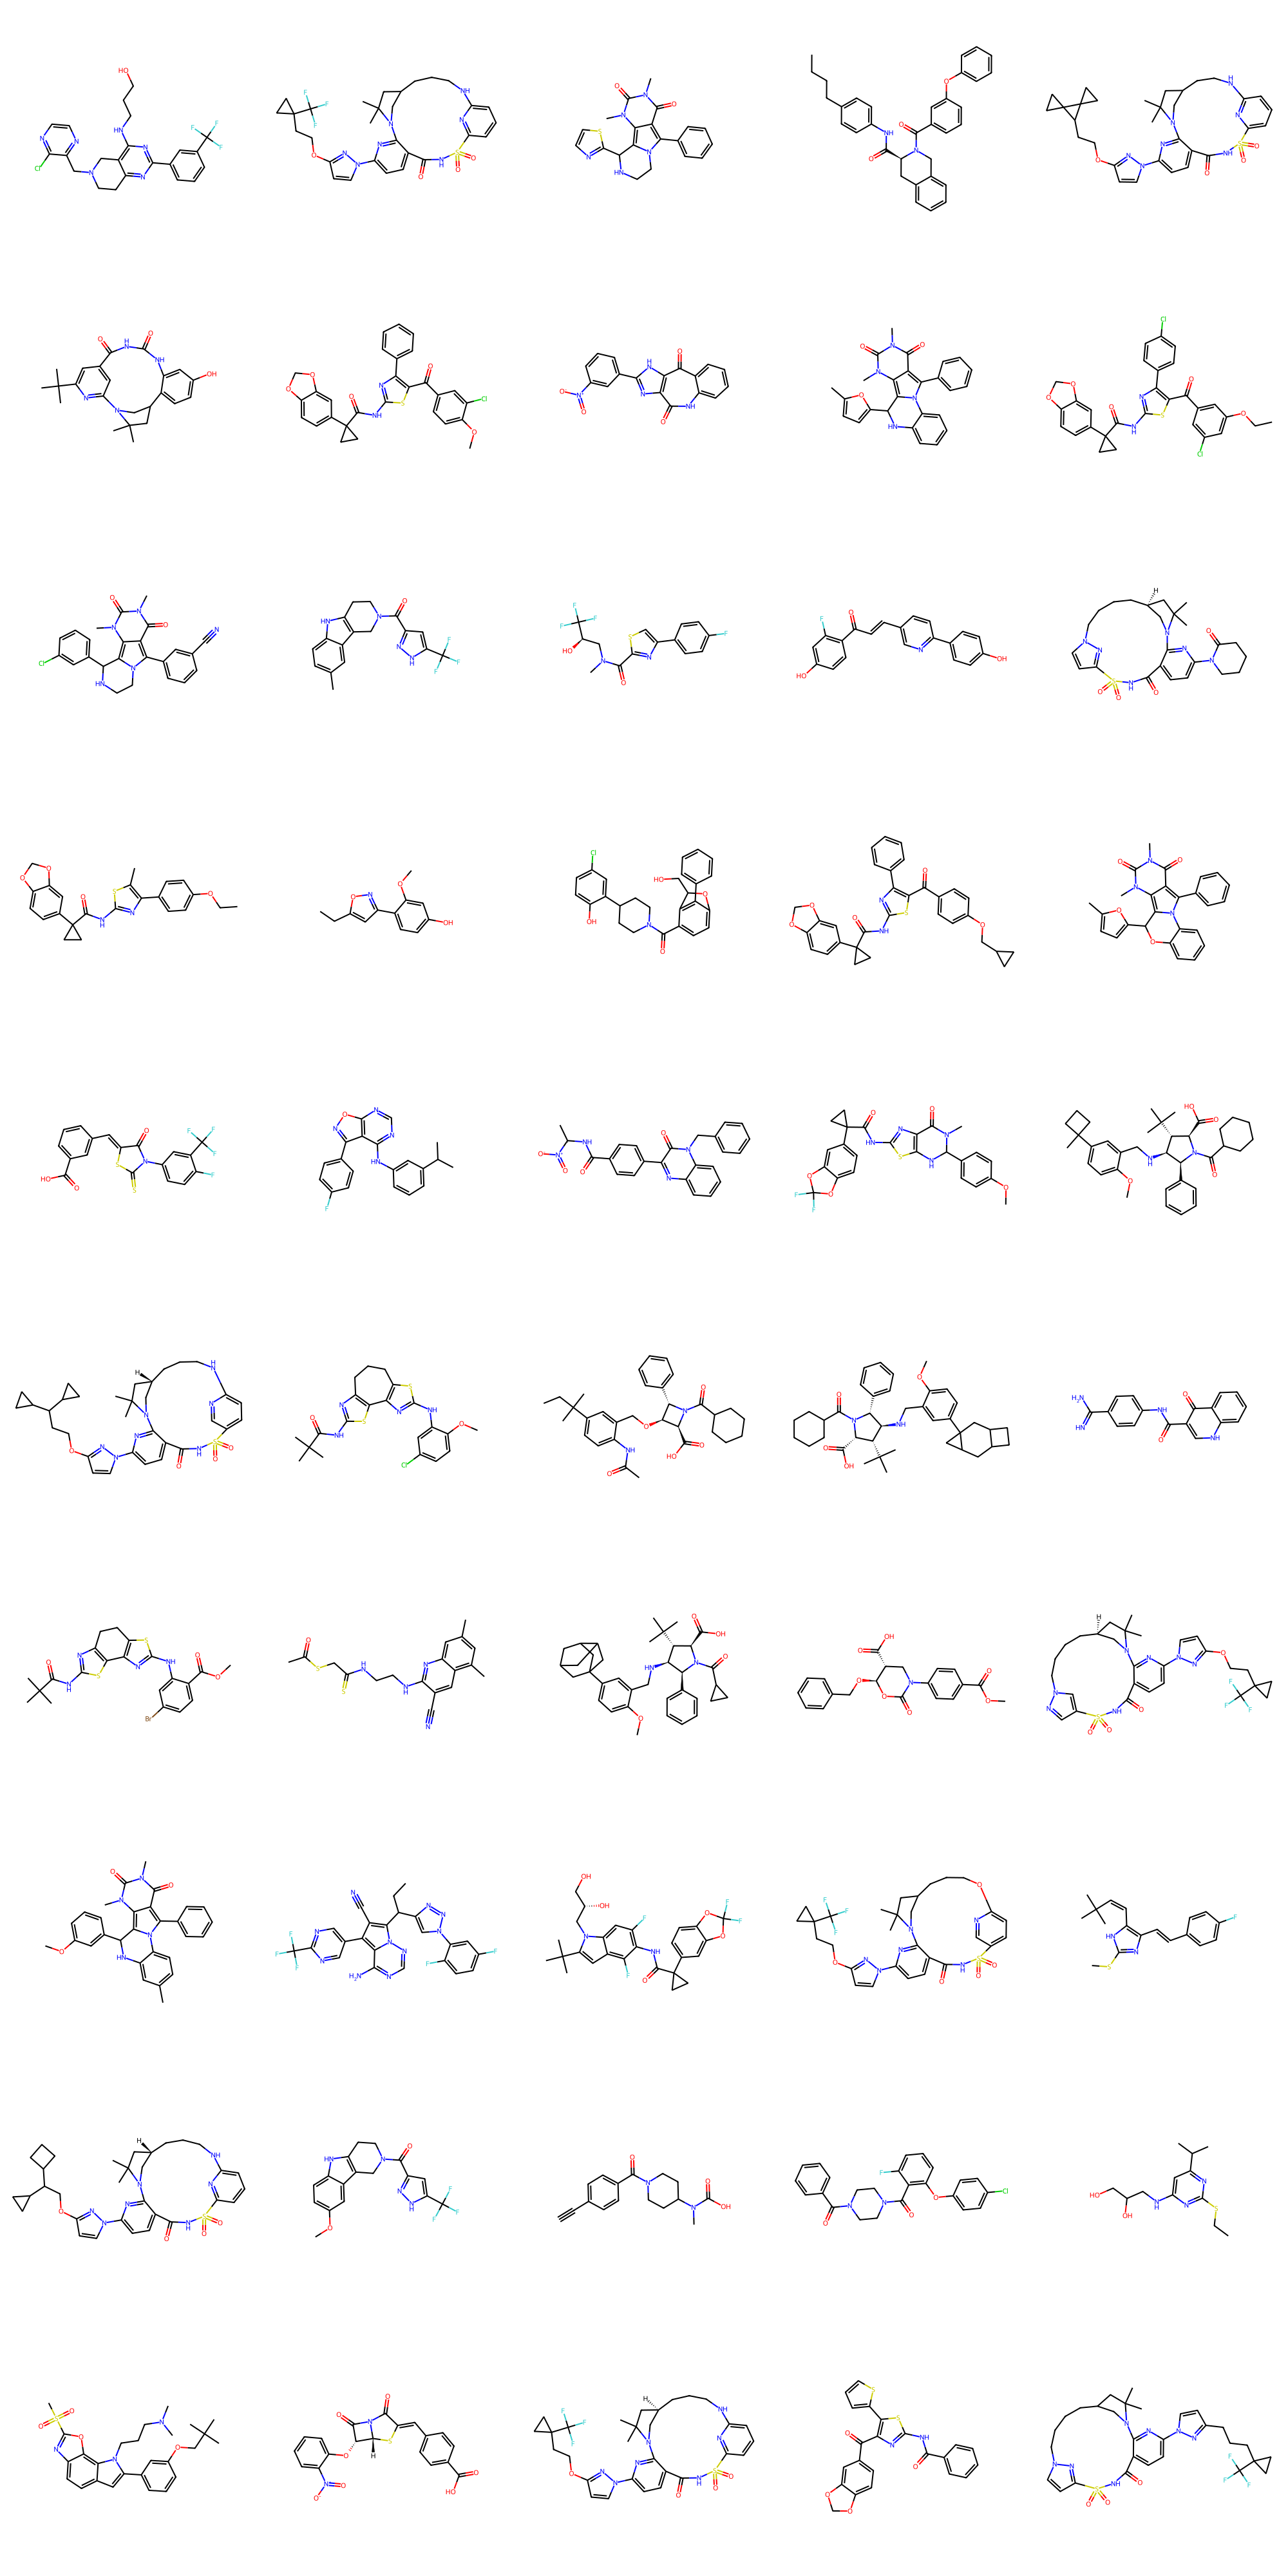

In [110]:
# Example: Display the first 10 unique valid SMILES strings as a grid image
molecule_list = [Chem.MolFromSmiles(smiles) for smiles in unique_valid_smiles_fine_tuned[:50]]

# Generate a grid image of the molecules
# Adjust 'subImgSize' for the size of each molecule image, and 'molsPerRow' for the layout
grid_image = Draw.MolsToGridImage(molecule_list, molsPerRow=5, subImgSize=(400, 400))

# Display the grid image
display(grid_image)

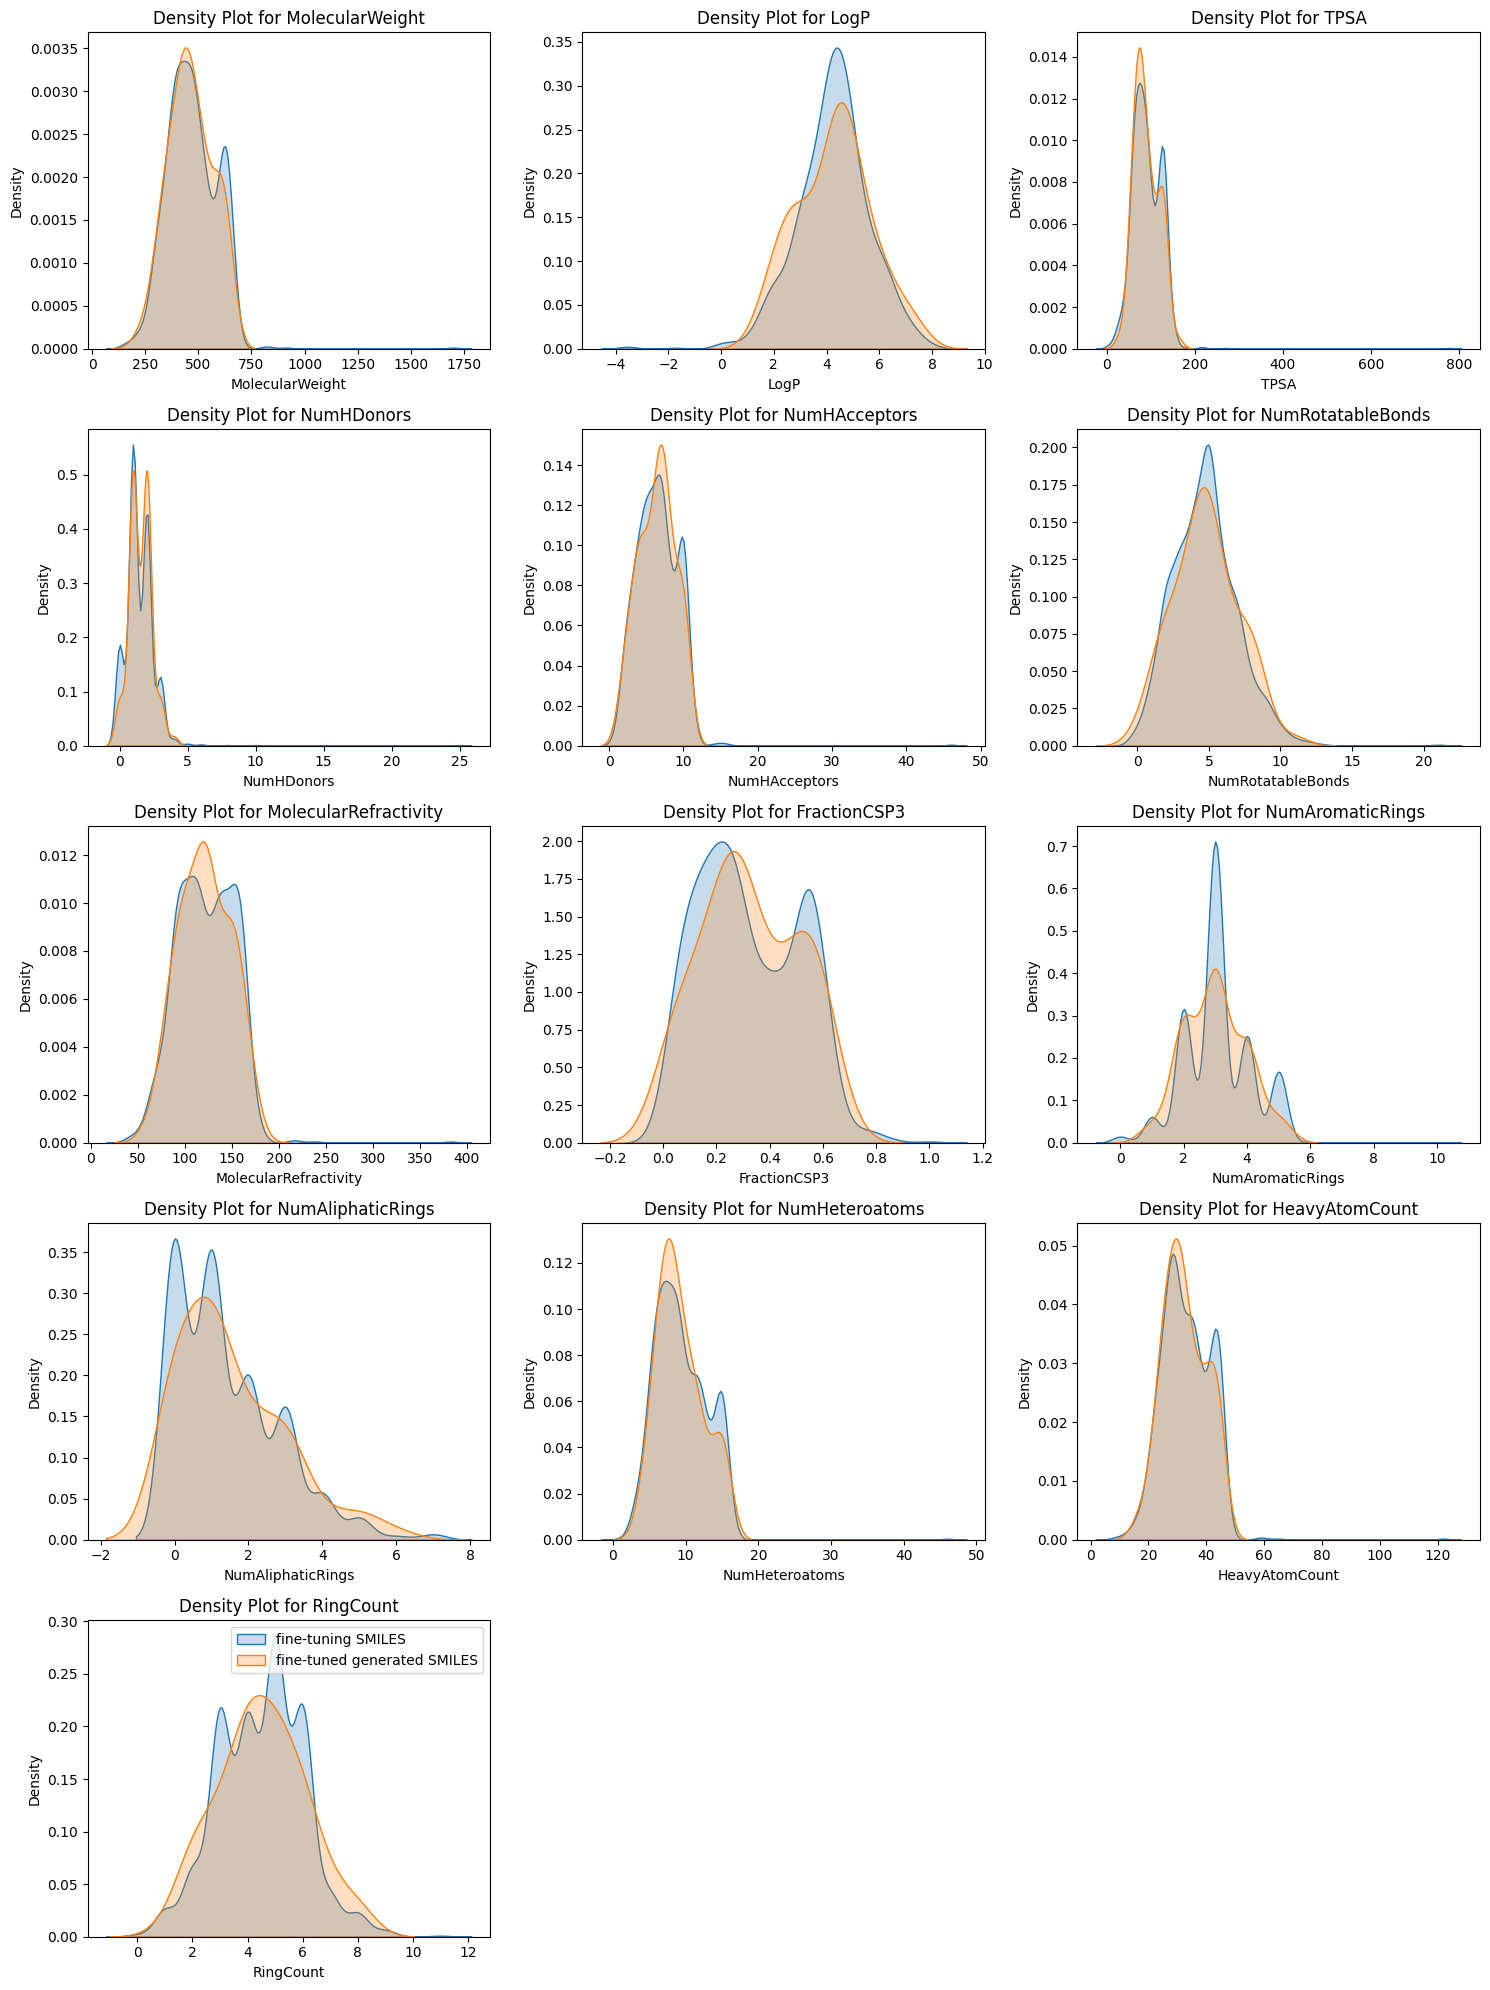

In [111]:
# Create dataframes from generated SMILES data to store molecular descriptors
fine_tuning_df = pd.DataFrame(fine_tuning_smiles_list, columns=['SMILES'])
generated_df_fine_tuned = pd.DataFrame(unique_valid_smiles_fine_tuned, columns=['SMILES'])

# Apply the descriptor function to each row in the dataframe
descriptor_columns_fine_tuned = fine_tuning_df['SMILES'].apply(compute_descriptors)
descriptor_columns_gen_fine_tuned = generated_df_fine_tuned['SMILES'].apply(compute_descriptors)

# Convert the series of dictionaries into a DataFrame
descriptors_fine_tuned_df = pd.DataFrame(descriptor_columns_fine_tuned.tolist())
descriptors_gen_df_fine_tuned = pd.DataFrame(descriptor_columns_gen_fine_tuned.tolist())

# Merge the descriptors back into the original dataframe
fine_tuning_data = pd.concat([fine_tuning_df, descriptors_fine_tuned_df], axis=1)
gen_data_fine_tuned = pd.concat([generated_df_fine_tuned, descriptors_gen_df_fine_tuned], axis=1)

# Display the updated dataframe
# Set up the matplotlib figure
plt.figure(figsize=(15, 20))

descriptor_cols = descriptors_df.columns.to_list()

# Loop through the columns and create a density plot for each
for i, column in enumerate(descriptor_cols, 1):
    plt.subplot(5, 3, i)
    sns.kdeplot(fine_tuning_data[column], fill=True, label='fine-tuning SMILES')
    sns.kdeplot(gen_data_fine_tuned[column], fill=True, label='fine-tuned generated SMILES')
    plt.title(f'Density Plot for {column}')
    plt.xlabel(column)
    plt.ylabel('Density')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.legend()
plt.show()


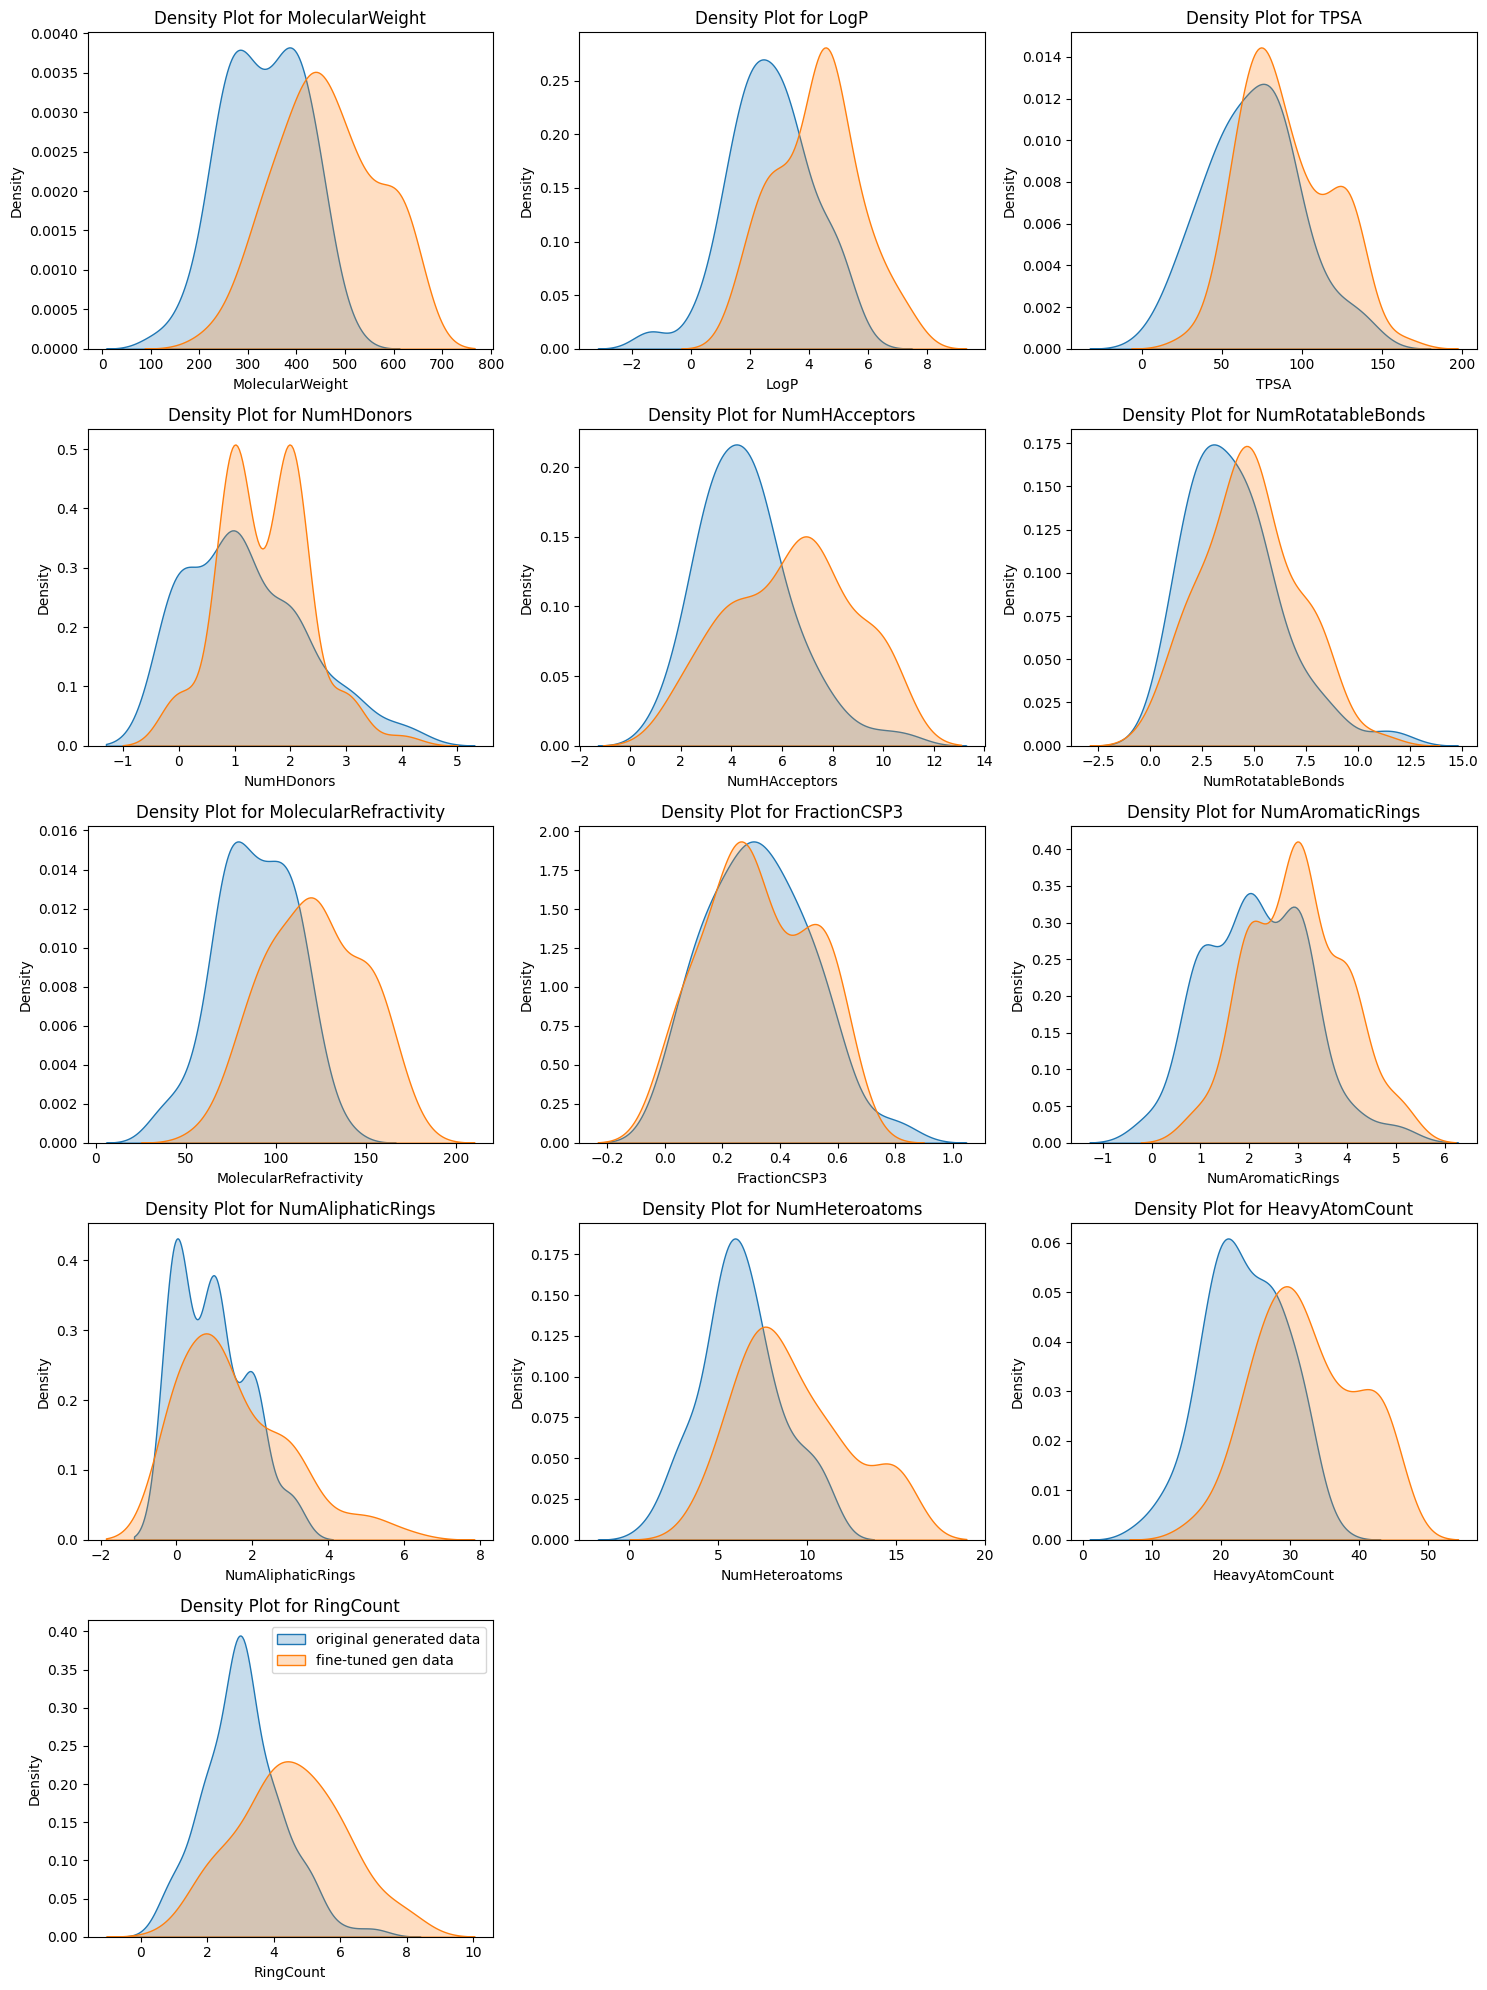

In [112]:
# Set up the matplotlib figure
plt.figure(figsize=(15, 20))

descriptor_cols = descriptors_df.columns.to_list()

# Loop through the columns and create a density plot for each
for i, column in enumerate(descriptor_cols, 1):
    plt.subplot(5, 3, i)
    sns.kdeplot(gen_data[column], fill=True, label='original generated data')
    sns.kdeplot(gen_data_fine_tuned[column], fill=True, label='fine-tuned gen data')
    plt.title(f'Density Plot for {column}')
    plt.xlabel(column)
    plt.ylabel('Density')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.legend()
plt.show()
